In [513]:
import os
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import numpy as np
 
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn.compose import ColumnTransformer
from scipy.stats import norm
import scipy.stats as stats
import numpy as np

---
# Inimse hingamise sageduse ja teiste füüsiliste parameetrite regressioonanalüüs
## ITB8814 Andmekaevandamine, Projekt
### Autor: Juri Lunin
Kuupäev 17.05.2024

<style>
body p {
  text-align: justify
}
</style>

# Sissejuhatus

<p>
Käesolevas projektitöö on valitud uurimiseks andmestik: "Energy Expenditure of Human Physical Activity".
</p>

## Andmestiku kirjeldus

Andmestikus on inimeste füüsilised omadused ja info nende seisundi kohta, mis avaldub füüsilise aktiivsuse ajal.
<a href="https://www.kaggle.com/datasets/anonymousds/energy-expenditure-of-human-physical-activity">Energy Expenditure of Human Physical Activity</a>  Faili formaat: csv*.

Andmestikuga koos on postitatud kaks teadusliku artikli:

<p>

<ul>

<li><a href="https://link.springer.com/article/10.1007/s11257-020-09268-2">Activity recognition using wearable sensors for tracking the elderly</a></li>

<li><a href="https://link.springer.com/article/10.1007/s10618-021-00817-w">A recurrent neural network architecture to model physical activity energy expenditure in older people</a></li>

</ul>

</p>

Andmestiku tunnused:

<ul>
<li>ID - participant's ID</li>
<li>trial_date - date and time when data collection started at ID level</li>
<li>gender - sex = male or female</li>
<li>age	in years</li>
<li>weight	in kg</li>
<li>height	in cm</li>
<li>bmi	Body mass index in kg/m</li>
<li>gaAnkle	TRUE if data from GENEActiv on the ankle exist, FALSE otherwise</li>
<li>gaChest	TRUE if data from GENEActiv on the chest exist, FALSE otherwise</li>
<li>gaWrist	TRUE if data from GENEActiv on the wrist exist, FALSE otherwise</li>
<li>equivital	TRUE if data from Equivital exist, FALSE otherwise</li>
<li>cosmed	TRUE if data from COSMED exist, FALSE otherwise</li>
<li>EEm	Energy Expenditure per minute, in Kcal</li>
<li>COSMEDset_row	the original indexes of COSMED data (used for merging)</li>
<li>EEh	Energy Expenditure per hour, in Kcal</li>
<li>EEtot	Total Kcal spent (it is reseted between indoor and outdoor measurements)</li>
<li>METS	Metabolic Equivalent per minute</li>
<li>Rf	Respiratory Frequency (litre/min)</li>
<li>BR	Breath Rate</li>
<li>VT	Tidal Volume in litre</li>
<li>VE	Expiratory Minute Ventilation (litre/min)</li>
<li>VO2	Oxygen Uptake (ml/min)</li>
<li>VCO2	Carbon Dioxide production (ml/min)</li>
<li>O2exp	Volume of O2 expired (ml/min)</li>
<li>CO2exp	Volume of CO2 expired (ml/min)</li>
<li>FeO2	Averaged expiratory concentration of O2 (%)</li>
<li>FeCO2	Averaged expiratory concentration of CO2 (%)</li>
<li>FiO2	Fraction of inspired O2 (%)</li>
<li>FiCO2	Fraction of inspired CO2 (%)</li>
<li>VE.VO2	Ventilatory equivalent for O2</li>
<li>VE.VCO2	Ventilatory equivalent for CO2</li>
<li>R	Respiratory Quotient</li>
<li>Ti	Duration of Inspiration (seconds)</li>
<li>Te	Duration of Expiration (seconds)</li>
<li>Ttot	Duration of Total breathing cycle (seconds)</li>
<li>VO2.HR	Oxygen pulse (ml/beat)</li>
<li>HR	Heart Rate</li>
<li>Qt	Cardiac output (litre)</li>
<li>SV	Stroke volume (litre/min)</li>
<li>original_activity_labels	True activity label as noted from study protocol, NA if is unknown</li>
<li>predicted_activity_label	Predicted activity label by model from [1], NA if is unknown</li>
</ul>

</p>

## Uurimiseesmärk

Prognoositav tunnus ehk sihttunnus on Y=“BR” breath rate.

Eesmärk: parima mitme argumendiga regressiooni mudeli leidmine sihttunnuse *BR* prognoosimiseks.

## Tööülesanded (tööhüpoteesid)

1. Madalama hingamise sagedusega inimestel on tugevam tervis.

## Metoodika ja uuringu käik

Käesoleva projektis kasutasime järgnevaid analüüsi meetodeid:

<ul>
<li>Lineaarregressioon</li>
<li>Polünomiaalregressioon</li>
<li>Otsustuspuu regressiooni mudel</li>
<li>Random forest regressiooni mudel</li>
</ul>

## Sisukord

* [Andmeteanalüüs](#andm)
* [Andmete lugemune](#luge)
* [Ülevaade andmestiku struktuurist](#str)
* [Andmestiku puhastamine](#puh)
* [Tunnuste teisendamine](#teis)
* [Tunnuste kirjeldus](#kirj)
* [Seoste analüüs](#seos)
* [Lineaarregressioon](#line)
* [Polünomiaalregressioon](#poly)
* [Otsustuspuu regressioon](#otsu)
* [Random Forest regressioon](#rand)
* [Kokkuvõtte](#summ)

In [514]:
_DATA_PATH = 'data/EEHPA.csv'
_SIHTTUNNUS_ = 'BR'
_GOAL_ = 'Leida parima mitme argumendiga regressiooni mudeli sihttunnuse BR ennustamise jaoks.'
_DROP_= ['age', 'weight', 'height', 'bmi', 'ID',
         'gaAnkle', 'gaChest', 'gaWrist', 'equivital', 'cosmed', 'COSMEDset_row',
         'trial_date',
         'VE.VO2', 'VE.VCO2', 'R', 'FiO2', 'FiCO2',
         'VO2', 'VCO2', 'EEm', 'EEh',
         'Ti', 'Te', 'Ttot',
         'Qt', 'SV']
_OBJ_CAST_= []
_DROP_UNNAMED_ = True

Andmestikus on liiga palju attribuute, mis ei mõjuta oluliselt uuringu tulemusi.
Kustutame selliseid andmestikust kohe. Mõned tunnused on tuvastatud mitteolulisteks seoste analüüsi käigus.

Kustutame 'ID'. See ei mängi rolli uuringus.

Kustutame boolean tunnused seadmetest andmete kohta:
'gaAnkle', 'gaChest', 'gaWrist', 'equivital', 'cosmed'
Need ei ole nii tähtsad ja nende väärtused on enamasti 'True'.

Kustutame ka 'COSMEDset_row', 'trial_date',
Need ei mängi rolli praeguses uuringus.

Kustutame 'FiO2', 'FiCO2' ning 'Qt', 'SV'.
Nendende vahel on ebamäärane seos, mis selgus seoste analüüsimisel.

Seoste analüüsi käigus on selgunud järgmised nõrgad ja loomulikud seosed, millised ei näita tugevat korrelatsiooni ega ole niivõrd huvitavad uuringus. Samuti need võivad segada, mis selgus peale Clustermap analüüsi:

Kustutame 'age', 'weight', 'height', 'bmi'.
Kustutame 'VE.VO2', 'VE.VCO2', 'R'. Nende kohta võiks eraldi uuringu teha, kuid praegu nad on liiga nõrga korrelatsiooniga.

Lineaarregressiooni mudeli tehes on avastatud, et attribuudid 'Ti', 'Te', 'Ttot' on liiga kõrge mõjuga, mis on loomulik ja need ei ole lineaarses sõltuvuses teiste tunnustega. Kustutame 'Ti', 'Te', 'Ttot'.

Kustutame ka 'VO2', 'VCO2', 'EEm', 'EEh'. Liiga suur kordajate vahe.

<a id='andm'></a>
# Andmeanalüüs

<a id='luge'></a>
## Andmete lugemine

In [515]:
df = pd.read_csv(_DATA_PATH)
df

ID        trial_date  gender     age  weight  height     bmi  \
0      GOTOV05  08/02/2016 13:42  female 61.6000 68.6000     162 26.1000   
1      GOTOV05  08/02/2016 13:42  female 61.6000 68.6000     162 26.1000   
2      GOTOV05  08/02/2016 13:42  female 61.6000 68.6000     162 26.1000   
3      GOTOV05  08/02/2016 13:42  female 61.6000 68.6000     162 26.1000   
4      GOTOV05  08/02/2016 13:42  female 61.6000 68.6000     162 26.1000   
...        ...               ...     ...     ...     ...     ...     ...   
38718  GOTOV36  30/05/2016 10:41  female 81.3000 72.0000     167 25.8000   
38719  GOTOV36  30/05/2016 10:41  female 81.3000 72.0000     167 25.8000   
38720  GOTOV36  30/05/2016 10:41  female 81.3000 72.0000     167 25.8000   
38721  GOTOV36  30/05/2016 10:41  female 81.3000 72.0000     167 25.8000   
38722  GOTOV36  30/05/2016 10:41  female 81.3000 72.0000     167 25.8000   

       gaAnkle  gaChest  gaWrist  ...      R     Ti     Te   Ttot  VO2.HR  \
0         True     True     True  ... 0.9846 0.9300 1.8600 2.7900  2.1250   
1         True     True     True  ... 1.0035 1.2600 1.1800 2.4400  2.2403   
2         True     True     True  ... 1.0399 0.9700 1.6900 2.6600  4.2051   
3         True     True     True  ... 1.0635 0.9600 2.0400 3.0000  4.3329   
4         True     True     True  ... 1.0307 1.1500 1.5700 2.7200  2.6086   
...        ...      ...      ...  ...    ...    ...    ...    ...     ...   
38718     True     True     True  ... 0.8145 1.0100 1.7400 2.7500  3.9375   
38719     True     True     True  ... 0.7833 1.1100 1.9100 3.0200  3.1757   
38720     True     True     True  ... 0.7643 0.8300 1.4100 2.2400  7.3279   
38721     True     True     True  ... 0.7948 1.2500 2.7700 4.0200  4.4365   
38722     True     True     True  ... 0.7068 1.1300 1.2900 2.4200  4.7681   

        HR  Qt  SV  original_activity_labels  predicted_activity_label  
0      102   0   0                       NaN                   sitting  
1      103   0   0                       NaN                       NaN  
2      104   0   0                       NaN                       NaN  
3      106   0   0            lyingDownRight                  standing  
4      106   0   0            lyingDownRight                       NaN  
...    ...  ..  ..                       ...                       ...  
38718   77   0   0                       NaN                  standing  
38719   77   0   0                       NaN                       NaN  
38720   77   0   0                       NaN                       NaN  
38721   77   0   0                       NaN                       NaN  
38722   77   0   0                       NaN                       NaN  

[38723 rows x 41 columns]

<a id='str'></a>

## Ülevaade andmestiku struktuurist

Andmestiku suurus:

In [516]:
print(f"Andmestikus on \033[1m{df.shape[0]}\033[0m ridu, neid iseloomustab \033[1m{df.shape[1]}\033[0m tunnust.")

Andmestikus on 38723 ridu, neid iseloomustab 41 tunnust.


Andmestiku muutujad:

In [517]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38723 entries, 0 to 38722
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        38723 non-null  object 
 1   trial_date                38723 non-null  object 
 2   gender                    38723 non-null  object 
 3   age                       38723 non-null  float64
 4   weight                    38723 non-null  float64
 5   height                    38723 non-null  int64  
 6   bmi                       38723 non-null  float64
 7   gaAnkle                   38723 non-null  bool   
 8   gaChest                   38723 non-null  bool   
 9   gaWrist                   38723 non-null  bool   
 10  equivital                 38723 non-null  bool   
 11  cosmed                    38723 non-null  bool   
 12  EEm                       38723 non-null  float64
 13  COSMEDset_row             38723 non-null  int64  
 14  EEh   

In [518]:
print_prop_num_count = len(df.select_dtypes(exclude=object).columns)
print_prop_obj_count = len(df.select_dtypes(include=object).columns)

print(f"Andmestikus on \033[1m{print_prop_num_count}\033[0m arvulist ja \033[1m{print_prop_obj_count}\033[0m mittearvulist muutujat")

Andmestikus on 36 arvulist ja 5 mittearvulist muutujat


In [519]:
if len(_OBJ_CAST_) > 0:
    obj_cast_l = {}
    for i in _OBJ_CAST_:
        if i in df:
            obj_cast_l.update({i: str})
    
    df = df.astype(obj_cast_l)
        
    df.info()

In [520]:
if len(_OBJ_CAST_) > 0:
    
    print("Teisendame järgmised tunnused kategoriaalseteks:")
    print(f"\033[1m{[i for i in _OBJ_CAST_]}\033[0m")
    
    print_prop_num_count = len(df.select_dtypes(exclude=object).columns)
    print_prop_obj_count = len(df.select_dtypes(include=object).columns)

    print(f"Andmestikus on \033[1m{print_prop_num_count}\033[0m arvulist ja \033[1m{print_prop_obj_count}\033[0m mittearvulist muutujat")

<a id='puh'></a>
## Andmestiku puhastamine

### Duplikaatide kontroll

In [521]:
duplicates = df.duplicated(keep='first').sum();
print(f"Andmestikus on leitud {duplicates} duplikaate.")

Andmestikus on leitud 28 duplikaate.


In [522]:
df.drop_duplicates(keep='first',inplace=True)
duplicates_new = df.duplicated(keep='first').sum()
print(f"Peale puhastamist andmestikus on leitud {duplicates_new} duplikaate.")

Peale puhastamist andmestikus on leitud 0 duplikaate.


<a id='teisj'></a>
# Tunnuste teisendamine

### Puuduvate andmetega objektide kontroll

In [523]:
missing_values_validation = df.isna().sum()
missing_values_validation

ID                              0
trial_date                      0
gender                          0
age                             0
weight                          0
height                          0
bmi                             0
gaAnkle                         0
gaChest                         0
gaWrist                         0
equivital                       0
cosmed                          0
EEm                             0
COSMEDset_row                   0
EEh                             0
EEtot                           0
METS                            0
Rf                              0
BR                              0
VT                              0
VE                              0
VO2                             0
VCO2                            0
O2exp                           0
CO2exp                          0
FeO2                            0
FeCO2                           0
FiO2                            0
FiCO2                           0
VE.VO2        

Puuduvate väärtustega 'N/A' kirjed puuduvad.

In [524]:
print(f"Puhastatud andmestikus on \033[1m{df.shape[0]}\033[0m ridu, neid iseloomustab \033[1m{df.shape[1]}\033[0m tunnust.")

Puhastatud andmestikus on 38695 ridu, neid iseloomustab 41 tunnust.


<a id='teisj'></a>
# Tunnuste teisendamine

In [525]:
if len(_DROP_) > 0:
    prep_validated_drop_list = []
    for i in _DROP_:
        if i in df:
            prep_validated_drop_list.append(i)
    
    if len(prep_validated_drop_list) > 0:
        df.drop(columns=prep_validated_drop_list,axis = 1, inplace = True)

In [526]:
if _DROP_UNNAMED_:   
    prep_empty_cols = df.columns.str.contains('unnamed',case = False)

    if len(np.where(prep_empty_cols == True)) > 0:
        df.drop(df.columns[prep_empty_cols],axis = 1, inplace = True)
    
df

gender   EEtot   METS      Rf  BR     VT      VE    O2exp  CO2exp  \
0      female  0.0000 0.9528 21.5054  92 0.4091  8.7978  73.1476 12.4463   
1      female  0.0097 1.0143 24.5902  90 0.4642 11.4144  85.4919 11.8342   
2      female  0.0940 1.9223 22.5564  84 0.8774 19.7902 159.3537 25.3007   
3      female  0.2080 2.0189 20.0000  85 0.9243 18.4858 164.5567 30.6057   
4      female  0.2703 1.2154 22.0588  89 0.5876 12.9624 107.3240 16.2210   
...       ...     ...    ...     ...  ..    ...     ...      ...     ...   
38718  female 85.4218 1.2031 21.8182  90 0.5650 12.3281 102.0947 13.8710   
38719  female 85.4871 0.9703 19.8675  92 0.5314 10.5573  96.9951 11.8312   
38720  female 85.5828 2.2391 26.7857  87 0.6436 17.2386 110.4581 19.6846   
38721  female 85.7260 1.3556 14.9254  92 0.7017 10.4733 120.3514 22.2344   
38722  female 86.1708 1.4569 24.7934  89 0.6028 14.9449 109.3362 12.8511   

         FeO2  FeCO2  VO2.HR   HR original_activity_labels  \
0     17.8803 3.0424  2.1250  102                      NaN   
1     18.4176 2.5495  2.2403  103                      NaN   
2     18.1628 2.8837  4.2051  104                      NaN   
3     17.8035 3.3113  4.3329  106           lyingDownRight   
4     18.2639 2.7604  2.6086  106           lyingDownRight   
...       ...    ...     ...  ...                      ...   
38718 18.0686 2.4549  3.9375   77                      NaN   
38719 18.2534 2.2265  3.1757   77                      NaN   
38720 17.1632 3.0586  7.3279   77                      NaN   
38721 17.1512 3.1686  4.4365   77                      NaN   
38722 18.1387 2.1320  4.7681   77                      NaN   

      predicted_activity_label  
0                      sitting  
1                          NaN  
2                          NaN  
3                     standing  
4                          NaN  
...                        ...  
38718                 standing  
38719                      NaN  
38720                      NaN  
38721                      NaN  
38722                      NaN  

[38695 rows x 15 columns]

In [527]:
print_prop_num_count = len(df.select_dtypes(exclude=object).columns)
print_prop_obj_count = len(df.select_dtypes(include=object).columns)

print(f"Andmestikus on \033[1m{print_prop_num_count}\033[0m arvulist ja \033[1m{print_prop_obj_count}\033[0m mittearvulist muutujat")

Andmestikus on 12 arvulist ja 3 mittearvulist muutujat


Andmestik sobib mudelitele ilma muutusteta.

<a id='kirj'></a>

# Tunnuste kirjeldus

## Arvuliste tunnuste kirjeldus

Arvuliste tunnuste karakteristikud:

In [528]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df.describe().T

count   mean    std   min    25%    50%    75%    max
EEtot  38695.00  73.08  52.11  0.00  34.37  63.59 100.59 291.44
METS   38695.00   2.85   1.81  0.00   1.47   2.39   3.87  15.23
Rf     38695.00  23.99  10.80  2.89  18.13  22.30  27.78 375.00
BR     38695.00  82.02  10.42 23.00  77.00  85.00  90.00  99.00
VT     38695.00   1.19   0.60  0.04   0.76   1.08   1.50   4.64
VE     38695.00  27.73  16.97  0.20  15.40  22.84  35.15 132.13
O2exp  38695.00 207.24 103.41  7.55 134.52 186.63 257.73 969.38
CO2exp 38695.00  39.00  23.83  0.00  21.42  33.96  51.19 167.76
FeO2   38695.00  17.49   0.75 12.74  17.05  17.51  17.94  22.43
FeCO2  38695.00   3.11   0.68  0.00   2.70   3.09   3.53   6.11
VO2.HR 38695.00   7.94   4.99  0.00   4.60   7.55  11.12  39.39
HR     38695.00  81.68  36.18  0.00  69.00  83.00 104.00 203.00

Visualiseerime arvuliste muutujate jaotused. Selleks eraldame andmestikust arvulised muutujad:

In [529]:
feature_columns=df.drop(_SIHTTUNNUS_, axis=1).select_dtypes(exclude=object).columns
feature_columns

Index(['EEtot', 'METS', 'Rf', 'VT', 'VE', 'O2exp', 'CO2exp', 'FeO2', 'FeCO2',
       'VO2.HR', 'HR'],
      dtype='object')

Arvuliste tunnuste jaotuste visualiseerimine: histogramm + karpdiagramm

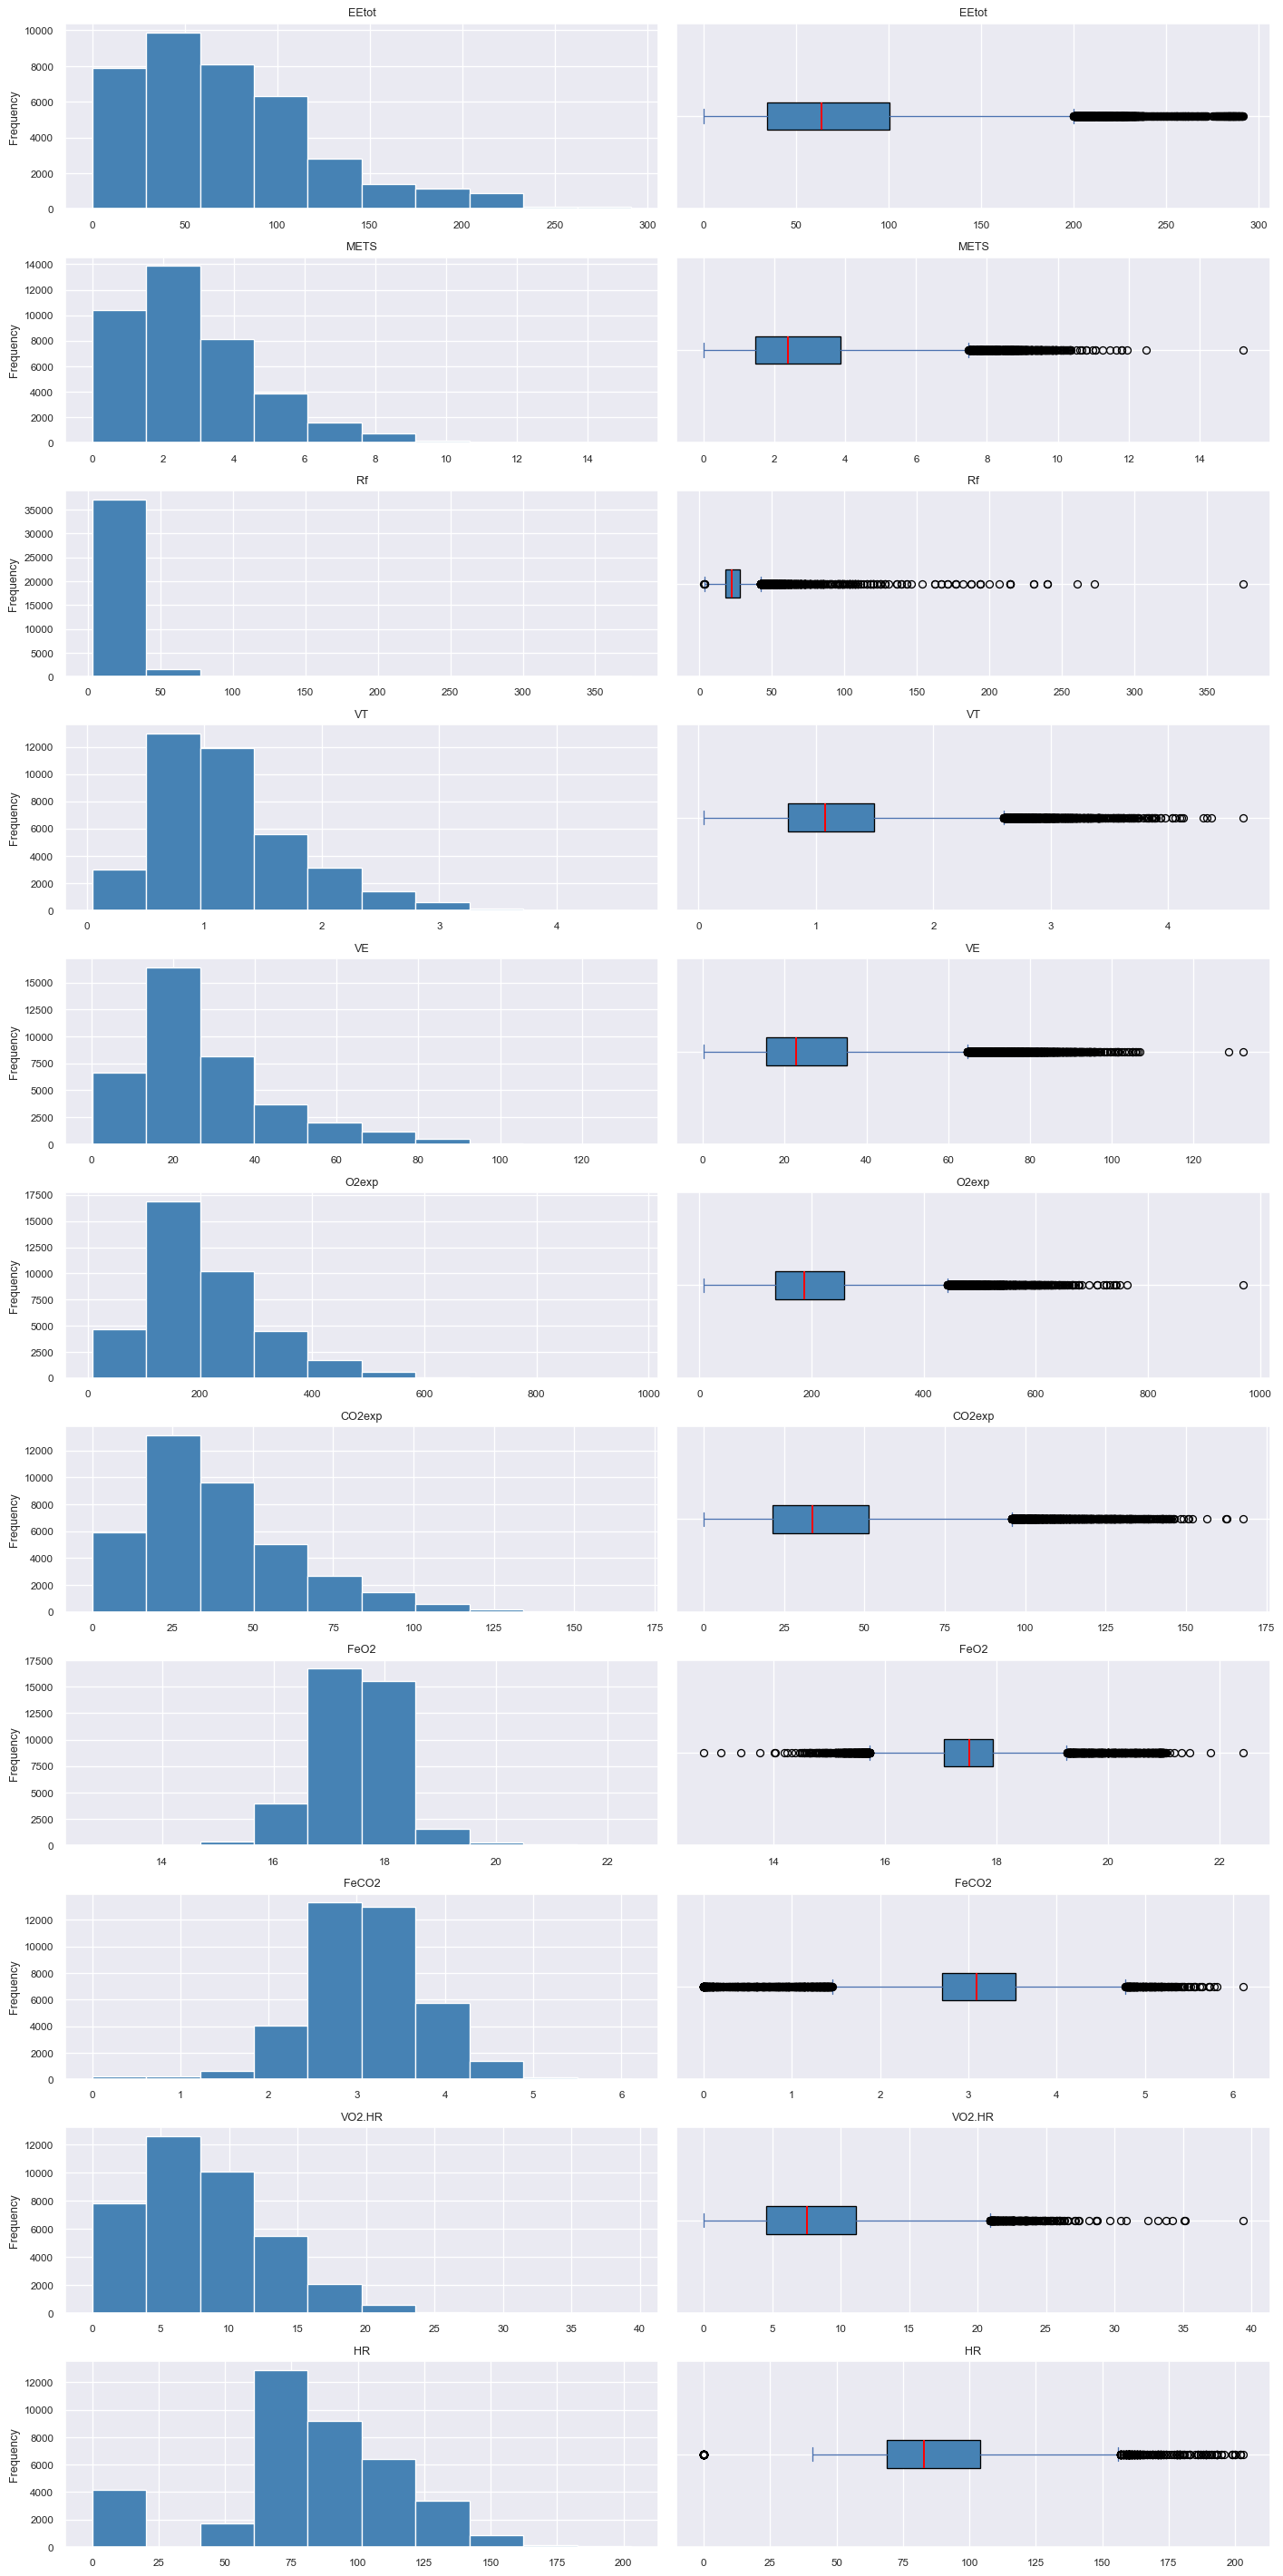

In [530]:
fig, axs = plt.subplots(len(feature_columns),2,dpi=95,figsize=(15,30))
i = 0
for col in feature_columns:
    df[col].plot(kind='hist',ax=axs[i,0], title=col, color="steelblue")
    df[col].plot(kind='box',vert=False,ax=axs[i,1], title=col,
                                             patch_artist = True,
           boxprops = dict(facecolor = "steelblue"),
                                             medianprops = dict(color = "red", linewidth = 1.5)).set_yticklabels('')

    i+=1
fig.tight_layout()
plt.show()

Järeldused siin:

## Mittearvuliste atribuutide kirjeldus

Mittearvuliste tunnuste karakteristikud:

In [531]:
df.describe(include=[object]).T

count unique       top   freq
gender                    38695      2      male  24786
original_activity_labels  24432     16   cycling   4212
predicted_activity_label  11367      7  standing   2675

Mittearvuliste tunnuste väärtuste sagedustabelid:

In [532]:
for column in df.select_dtypes(include=object).columns:
    print(column)
    print(df[column].value_counts().sort_index())
    print()

gender
gender
female    13909
male      24786
Name: count, dtype: int64

original_activity_labels
original_activity_labels
cycling            4212
dishwashing        1885
lyingDownLeft      1459
lyingDownRight     1307
sittingChair       1546
sittingCouch       1623
sittingSofa        1549
stakingShelves     1689
standing           1102
step                413
syncJumping         161
vacuumCleaning     1744
walkingFast        1997
walkingNormal      1883
walkingSlow        1694
walkingStairsUp     168
Name: count, dtype: int64

predicted_activity_label
predicted_activity_label
cycling      1369
household    2380
jumping        53
lyingDown     802
sitting      1667
standing     2675
walking      2421
Name: count, dtype: int64



Järeldused siin:

### Sihttunnuse Y kirjeldus

In [533]:
print(f"Sihttunnus: Y = \033[1m{_SIHTTUNNUS_}\033[0m.")

Sihttunnus: Y = BR.


Sihttunnuse jaotuse visualiseerimine:

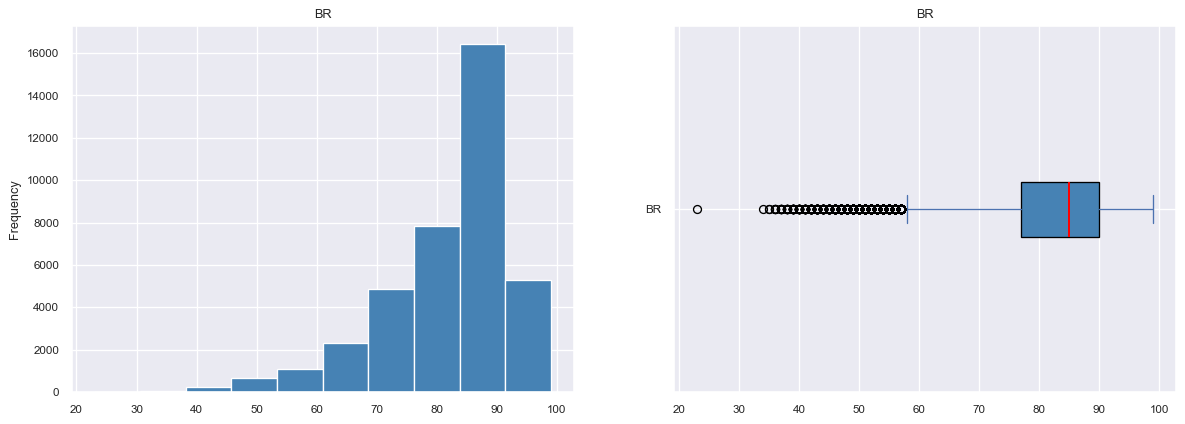

In [534]:
fig, axs = plt.subplots(1,2,dpi=95,figsize=(15,5))
df[_SIHTTUNNUS_].plot(kind='hist',ax=axs[0], title="{}".format(_SIHTTUNNUS_), color="steelblue")
df[_SIHTTUNNUS_].plot(kind='box',vert=False,ax=axs[1], title="{}".format(_SIHTTUNNUS_),
                                             patch_artist = True,
           boxprops = dict(facecolor = "steelblue"),
                                             medianprops = dict(color = "red", linewidth = 1.5))
plt.show()

Sihttunnuse histogramm näitab vasakpoolset assümmeetriat. Järeldused siin.

<a id='seos'></a>
# Seoste analüüs

## Seosed arvuliste tunnuste vahel

Visualiseerime arvuliste tunnuste vahelised sõltuvused

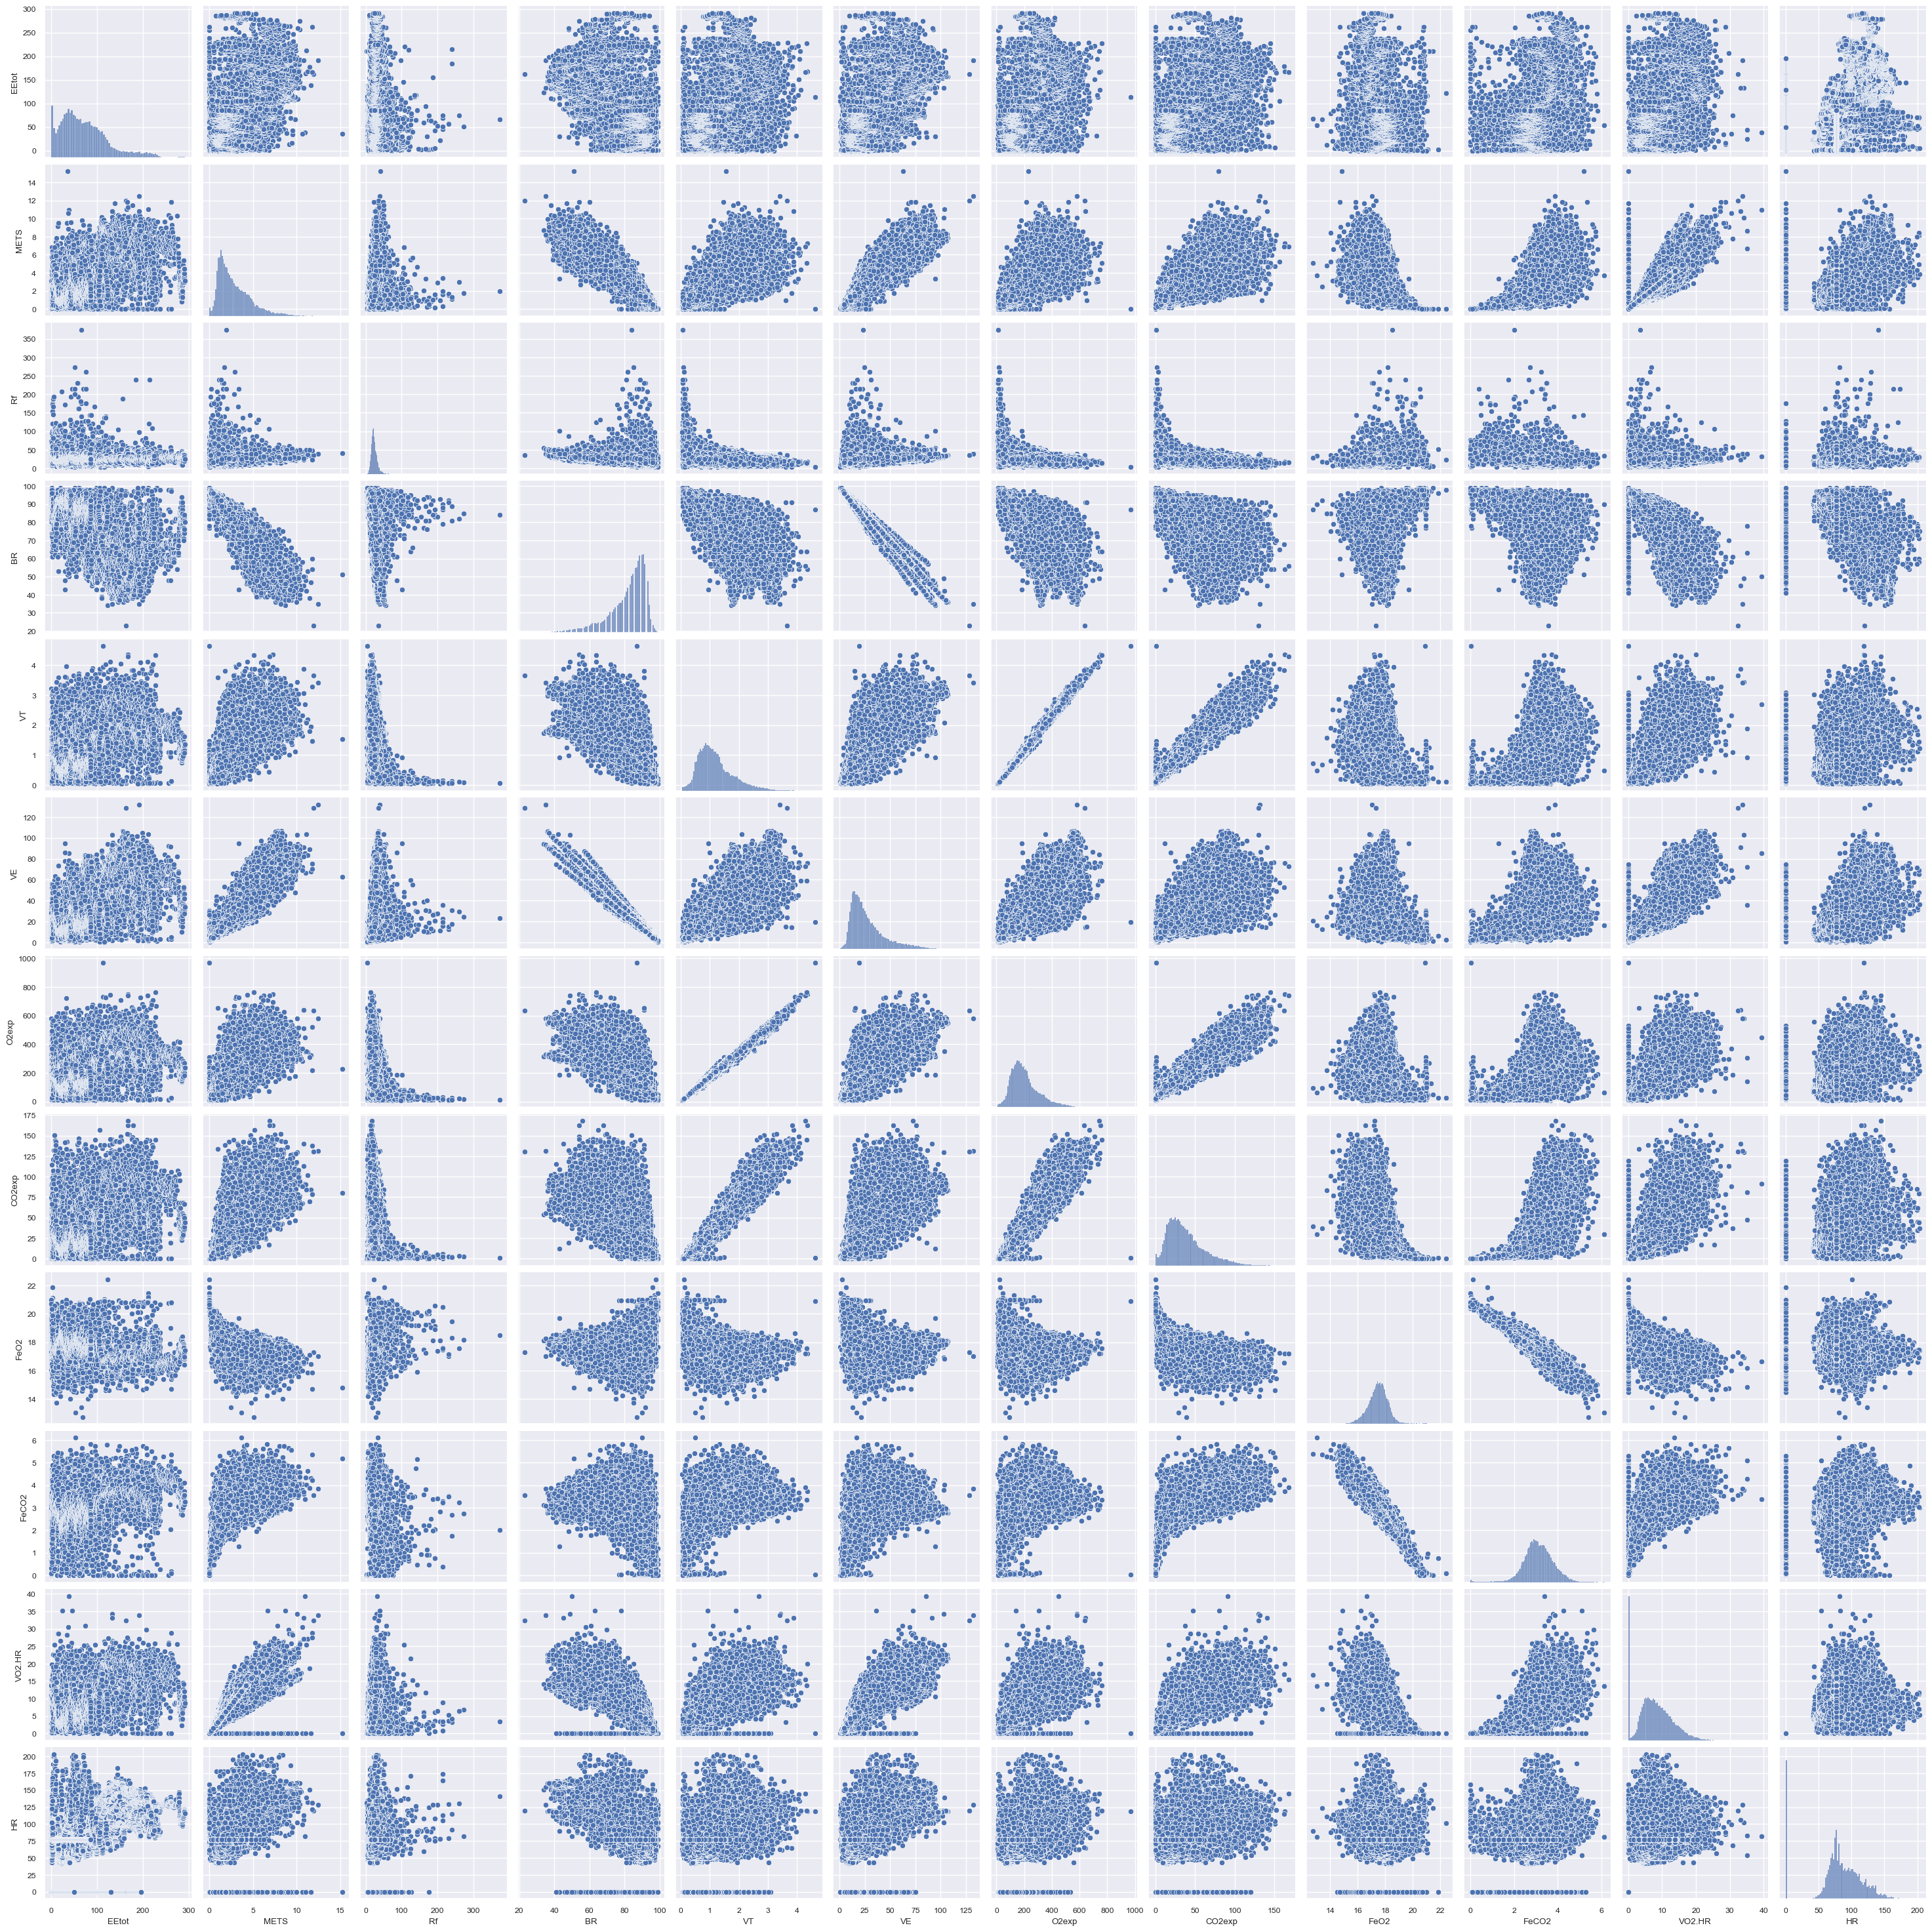

In [535]:
sns.pairplot(df.select_dtypes(exclude=object))
plt.show()

Lineaarne sõltuvus on nähtav tunnustel: SKLJD ja KFDJAL.
Teistel tunnuste paaridel on nõrk sõltuvus või suur hajutatus / puuduv struktuur.

## Korrelatsioonimaatriks

Arvuliste tunnuste korrelatsioonimaatriks:

In [536]:
df.select_dtypes(exclude=object).corr()

EEtot  METS    Rf    BR    VT    VE  O2exp  CO2exp  FeO2  FeCO2  \
EEtot    1.00  0.46  0.18 -0.51  0.43  0.55   0.44    0.40 -0.02   0.16   
METS     0.46  1.00  0.26 -0.91  0.73  0.90   0.71    0.77 -0.44   0.56   
Rf       0.18  0.26  1.00 -0.35 -0.14  0.32  -0.13   -0.15  0.23  -0.19   
BR      -0.51 -0.91 -0.35  1.00 -0.73 -0.97  -0.74   -0.67  0.14  -0.31   
VT       0.43  0.73 -0.14 -0.73  1.00  0.79   1.00    0.95 -0.32   0.47   
VE       0.55  0.90  0.32 -0.97  0.79  1.00   0.80    0.73 -0.15   0.31   
O2exp    0.44  0.71 -0.13 -0.74  1.00  0.80   1.00    0.92 -0.25   0.41   
CO2exp   0.40  0.77 -0.15 -0.67  0.95  0.73   0.92    1.00 -0.51   0.67   
FeO2    -0.02 -0.44  0.23  0.14 -0.32 -0.15  -0.25   -0.51  1.00  -0.91   
FeCO2    0.16  0.56 -0.19 -0.31  0.47  0.31   0.41    0.67 -0.91   1.00   
VO2.HR   0.35  0.69  0.10 -0.63  0.68  0.71   0.67    0.68 -0.37   0.42   
HR       0.32  0.39  0.14 -0.47  0.44  0.50   0.44    0.39 -0.01   0.12   

        VO2.HR    HR  
EEtot     0.35  0.32  
METS      0.69  0.39  
Rf        0.10  0.14  
BR       -0.63 -0.47  
VT        0.68  0.44  
VE        0.71  0.50  
O2exp     0.67  0.44  
CO2exp    0.68  0.39  
FeO2     -0.37 -0.01  
FeCO2     0.42  0.12  
VO2.HR    1.00  0.58  
HR        0.58  1.00

Korrelatsioonimaatriksi *heatmap* visualiseermine. Eraldame andmestikust arvulised tunnused:

In [537]:
num_f=df.select_dtypes(exclude=object)

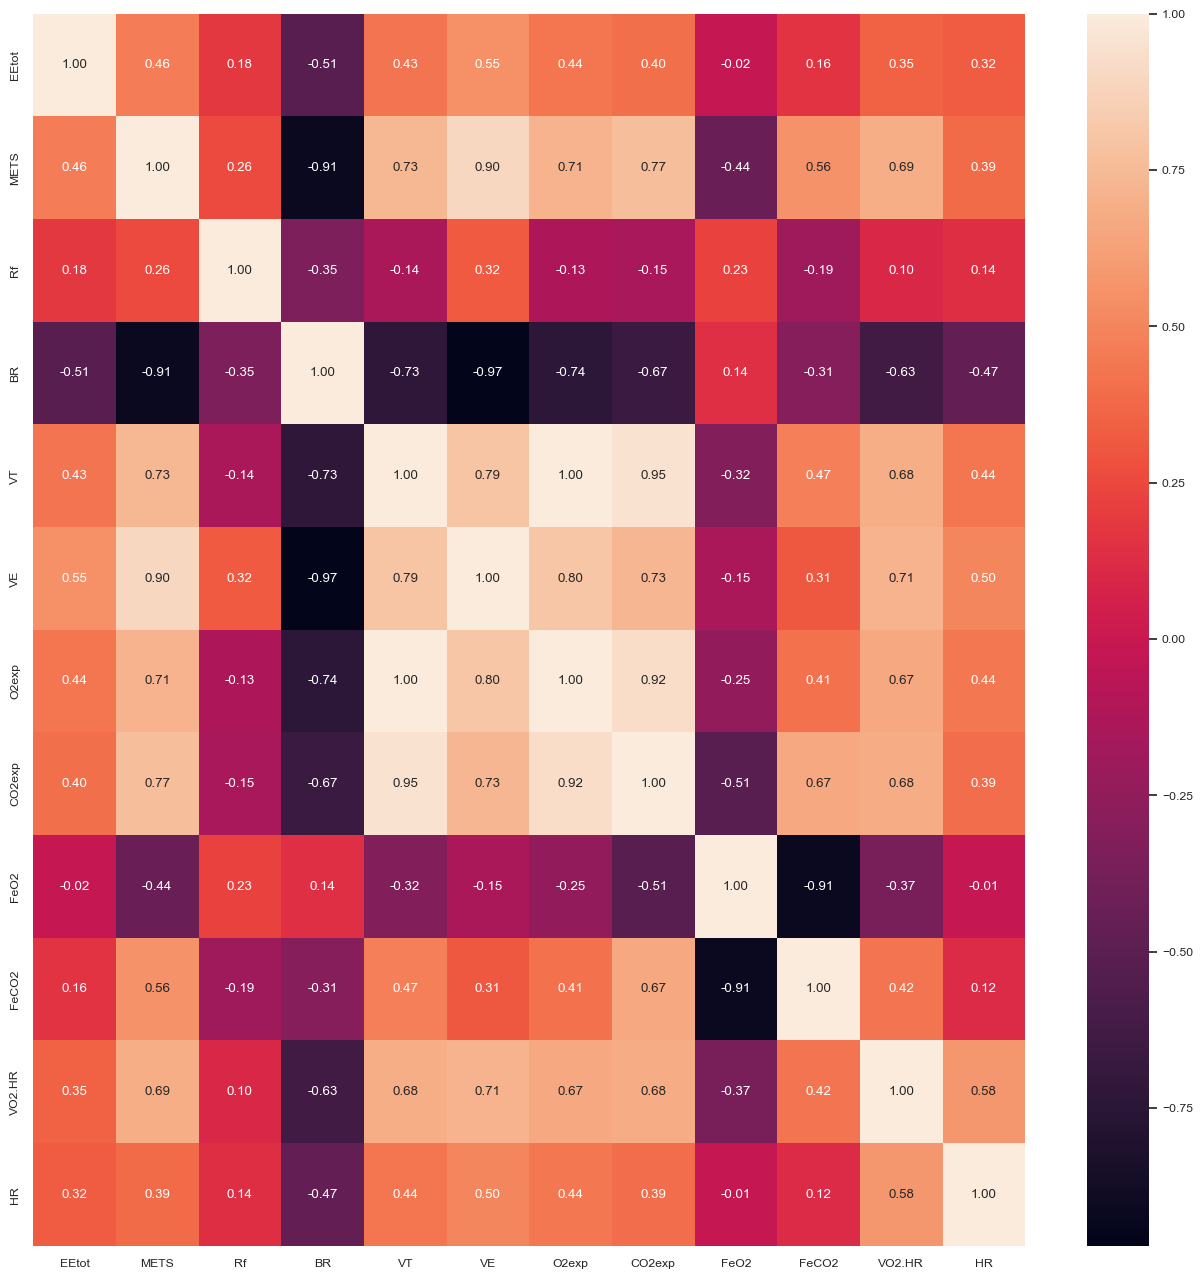

In [538]:
plt.figure(figsize=(16,16))
sns.heatmap(num_f.corr(), annot=True, fmt= '.2f')
plt.show()

Korrelatsiooni ülevaade *diverging_palette*'is.

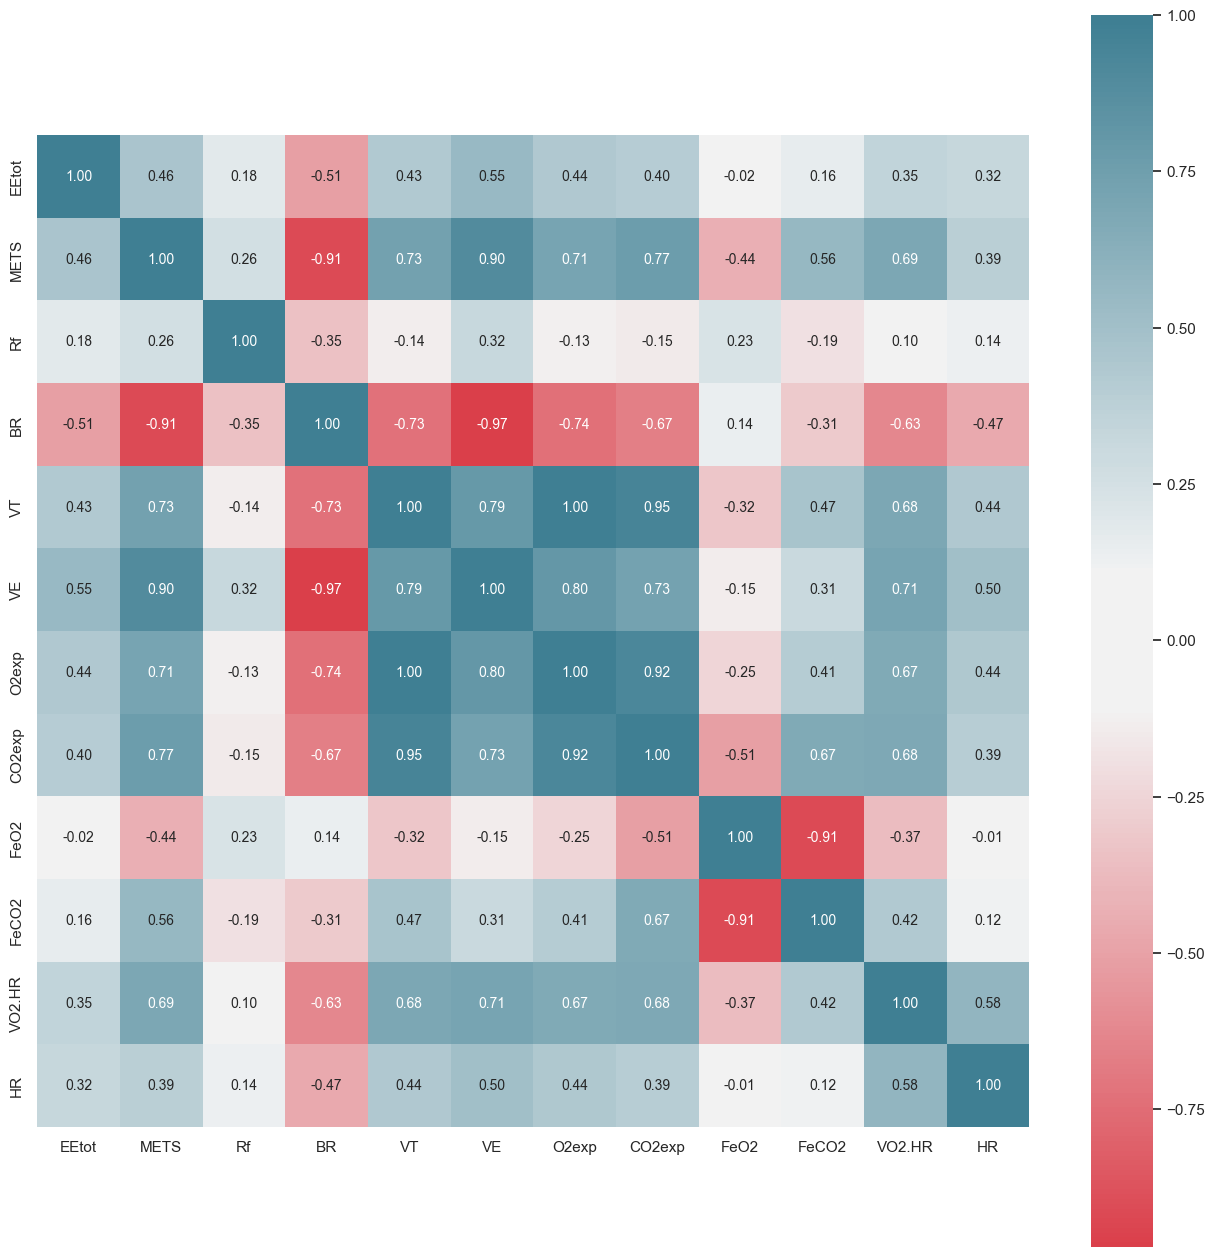

In [539]:
plt.figure(figsize=(16,16))
sns.set(font_scale=1.0)
hm = sns.heatmap(num_f.corr(), 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f',
                 annot_kws={'size': 10}, 
                 yticklabels=num_f.columns,
                 xticklabels=num_f.columns,
                 cmap=sns.diverging_palette(10, 220, sep=30, n=256),
                 center=0.0)
plt.show()

Kõige tugevamad seosed on tunnustel:
* JFDH ja KLFJAÖL (0.xx)
* JFDH ja KLFJAÖL (0.xx)
* JFDH ja KLFJAÖL (0.xx)

Clustermap järjestab read ja veerud sellisel viisil, et sarnaste väärtustega / lähedased veerud paiknevad diagrammil lähemal.
Niivisi rganiseerides eelnevalt saadud korrelatsioonimaatriksid, näeme tunnuste rühmasid tugevate omavaheliste seostega. See võimaldab teha järeldust multikollineaarsuse kohta.

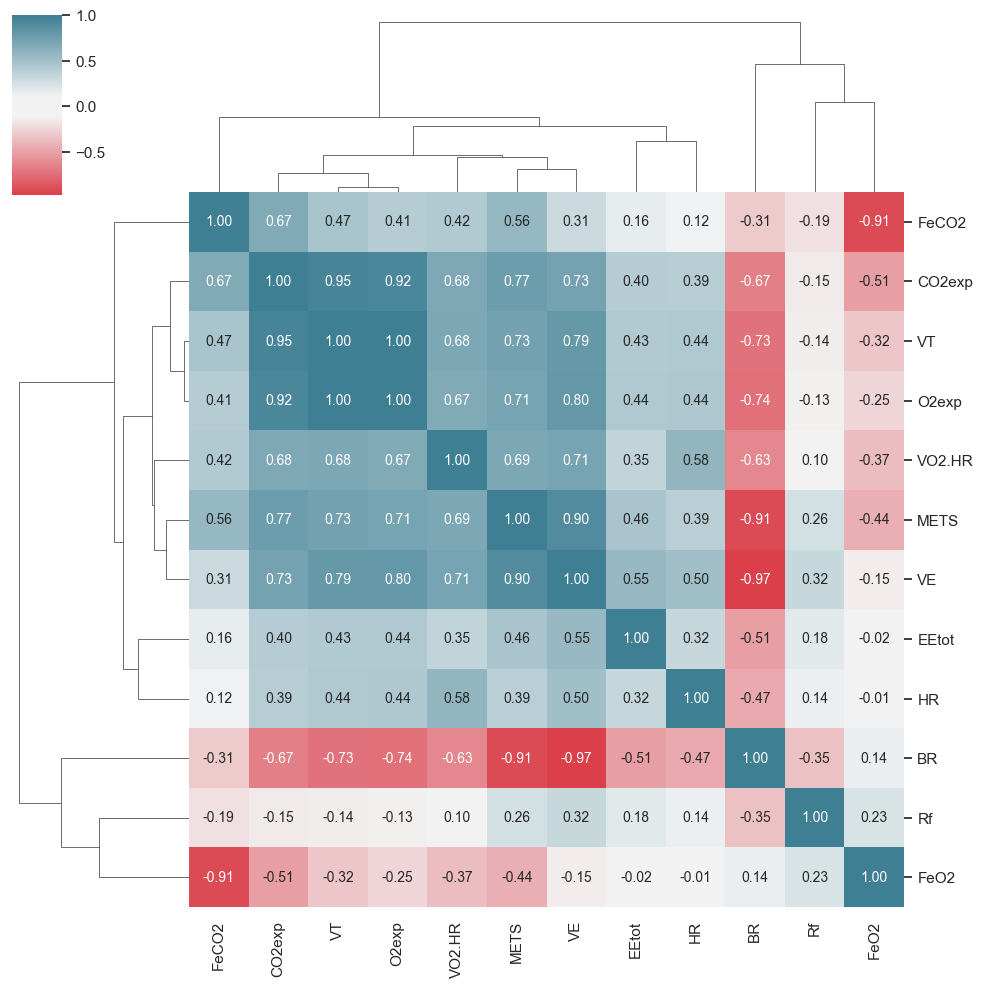

In [540]:
sns.set(font_scale=1.0)
km = sns.clustermap(num_f.corr(), 
                    cbar=True, 
                    annot=True,
                    fmt='.2f',
                    annot_kws={'size': 10}, 
                    yticklabels=num_f.columns,
                    xticklabels=num_f.columns,
                    cmap=sns.diverging_palette(10, 220, sep=30, n=256),
                    center=0.0)
plt.show()

Tunnused XXXXX ja XXXXXX on gruppeeritud esimesel tasandil. Rohkem kui kahe liikmega esimesel tasandil klastreid ei esine. Se tähendab, et multikollineaarsust ei ole.

Leiame arvuliste tunnuste korrelatsioonid (Pearsoni korrelatsioonikordajad) sihttunnusega, sorteerides need kasvavas järjekorras. See võimaldab näha, millised tunnused on kõige nõrgemas või tugevamas seoses sihttunnusega *BR*.

In [541]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
num_f.corrwith(df[_SIHTTUNNUS_]).sort_values()

VE       -0.9704
METS     -0.9097
O2exp    -0.7376
VT       -0.7272
CO2exp   -0.6652
VO2.HR   -0.6300
EEtot    -0.5134
HR       -0.4657
Rf       -0.3460
FeCO2    -0.3060
FeO2      0.1410
BR        1.0000
dtype: float64

Kuvame seda graafiliselt.

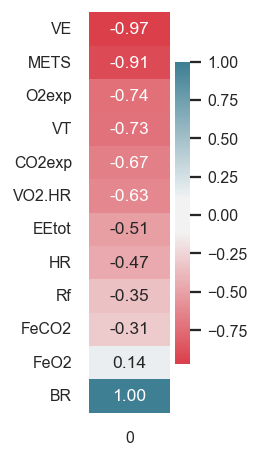

In [542]:
plt.figure(dpi=130,figsize=(1,4))
sns.set(font_scale=0.8)
sns.heatmap(pd.DataFrame(num_f.corrwith(df[_SIHTTUNNUS_]).sort_values()), fmt='.2f',
            annot=True, cmap=sns.diverging_palette(10, 220, sep=30, n=256),
                 center=0.0)
plt.show()

Kõige mõjukamad tunnused peale puhastamist ja esimese lineaarregressiooni mudeli sobitmist on:
* VE        Expiratory Minute Ventilation (litre/min)
* METS	    Metabolic Equivalent per minute
* O2exp	    Volume of O2 expired (ml/min)
* VT        Tidal Volume in litre
* CO2exp	Volume of CO2 expired (ml/min)
* VO2.HR	Oxygen pulse (ml/beat)

Selgub, et sügavam hingamine füüsilise energia kuluga mõjutab hingamise sagedusele kõige rohkem.

## Sihttunnuse seos mittearvuliste tunnustega

Arvutame ja kuvame sihtuunnuse seoseid mittearvuliste tunnustega *boxplot* diagrammidega.

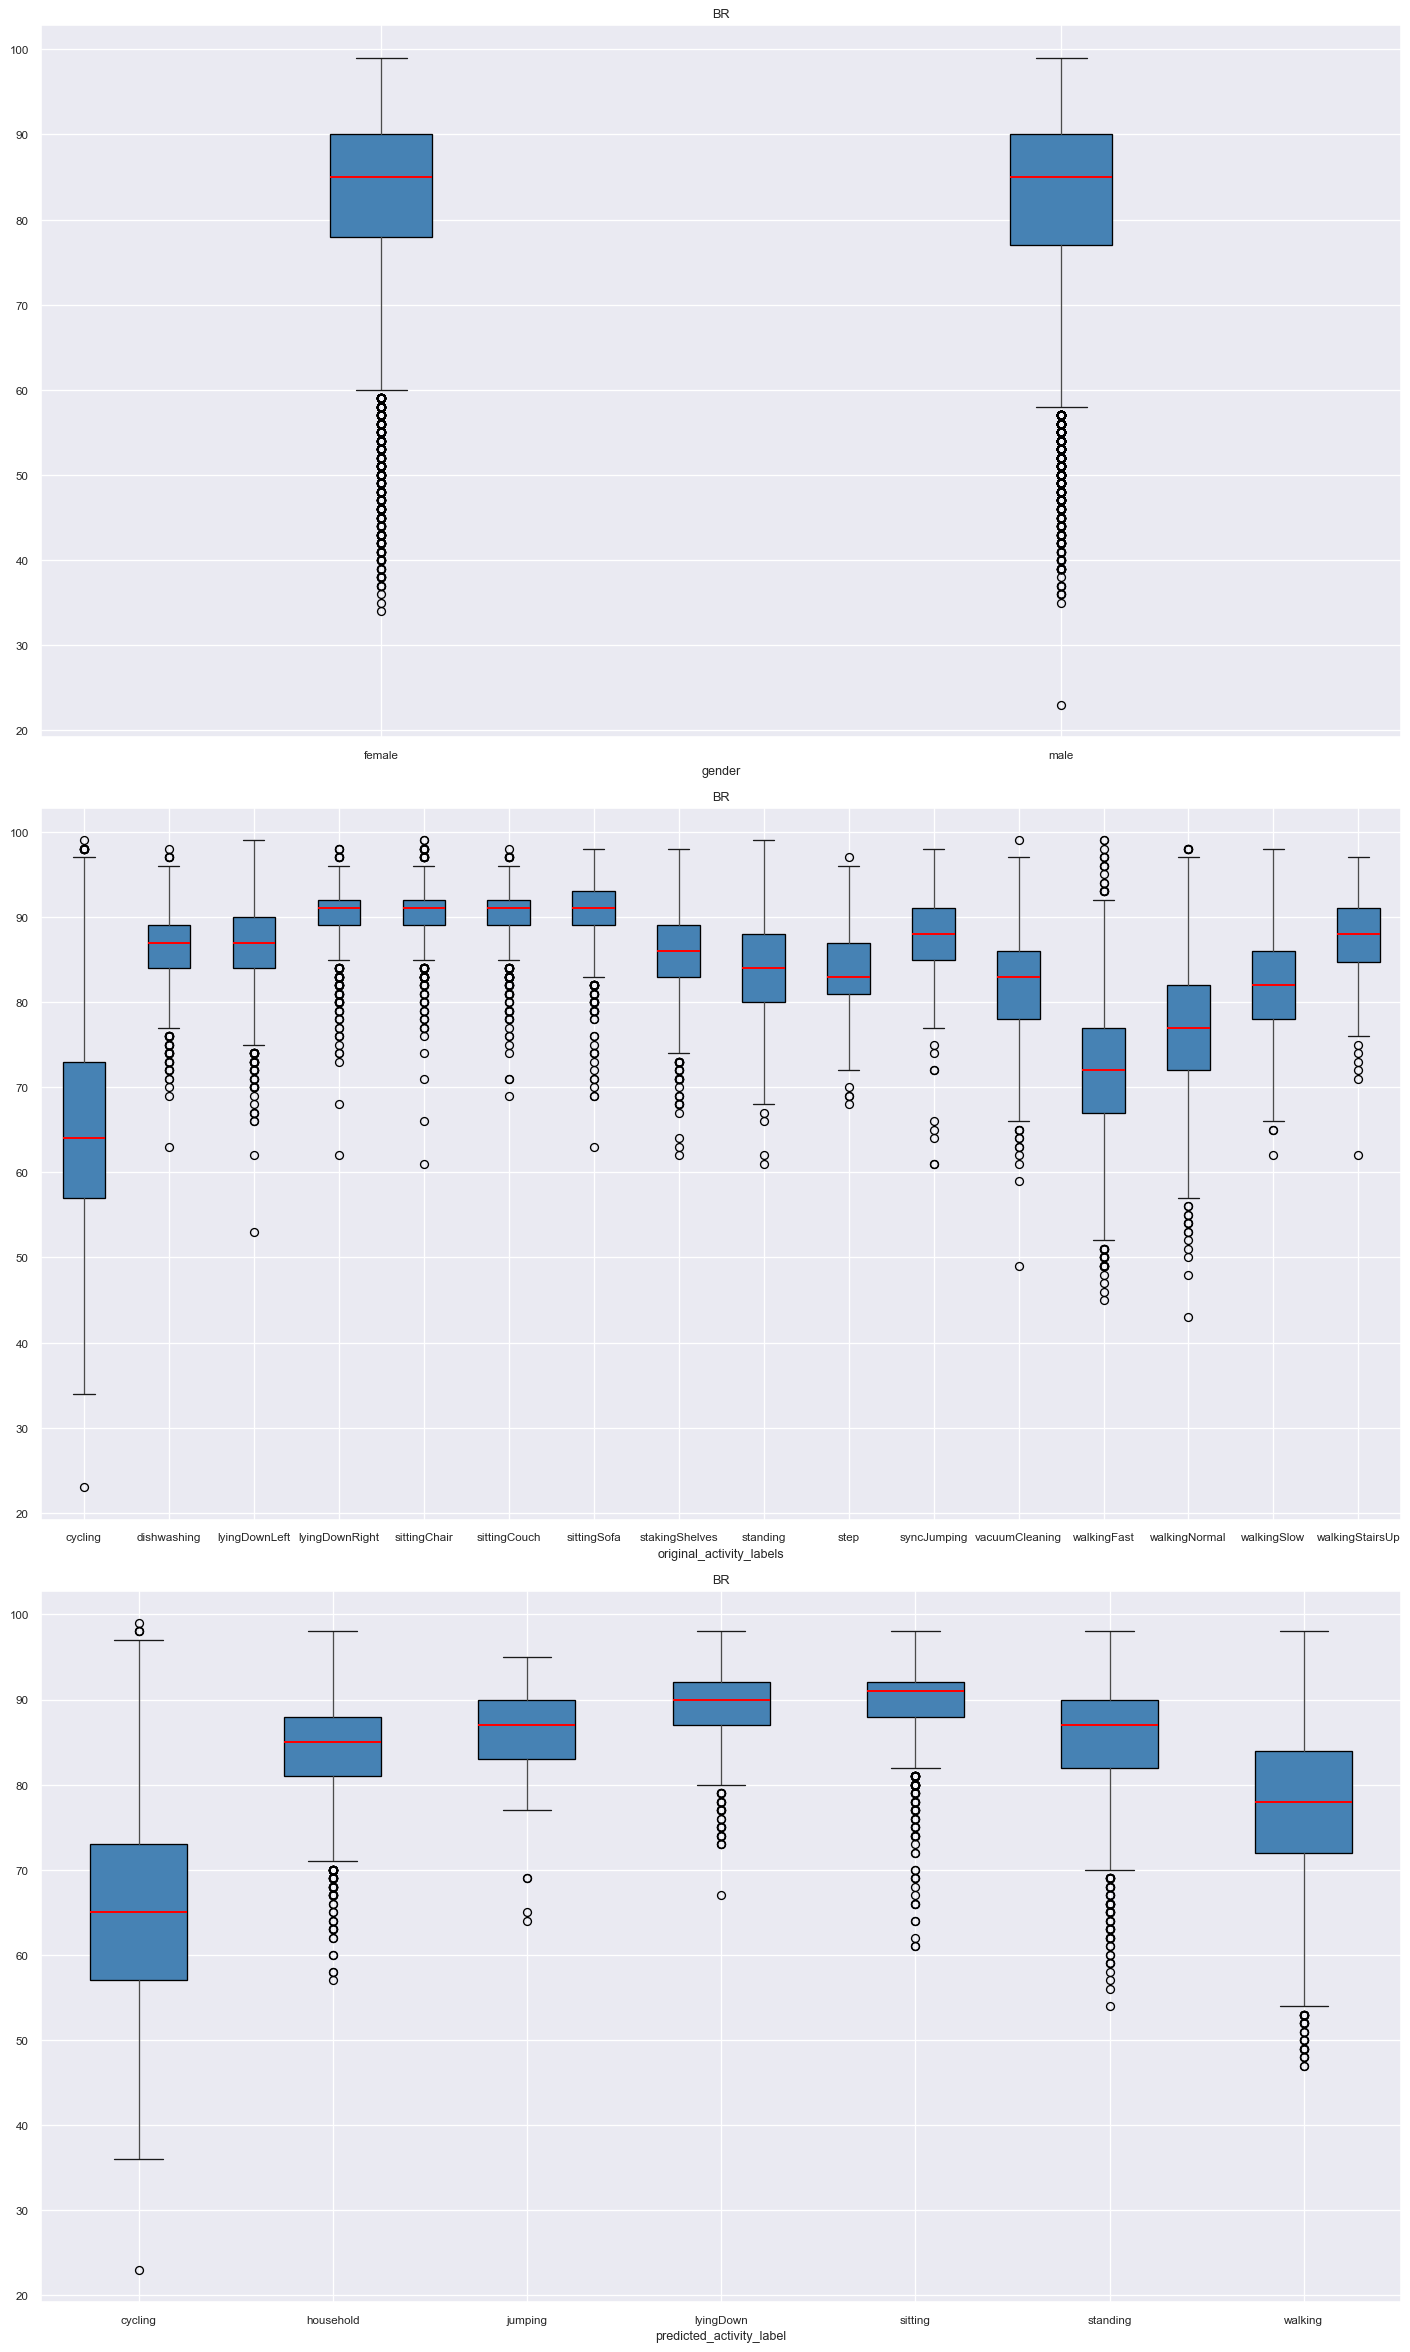

In [543]:
categ_columns=df.select_dtypes(include=object).columns
fig, axs = plt.subplots(len(categ_columns),1,dpi=95,figsize=(15,25))
i = 0
for col in categ_columns:
        df.boxplot(
            column=[_SIHTTUNNUS_],
            by=col,
            ax=axs[i],
            patch_artist = True,
            boxprops = dict(facecolor = "steelblue"),
            medianprops = dict(color = "red", linewidth = 1.5)
        )
        i+=1
plt.suptitle('')
fig.tight_layout()
plt.show()

Tunnusega XXXXX sõltuvuse struktuur on ühtlane, kuid tunnusega XXXXCFD erineb categooria *FFFGDDD*. Selle kategooria JFADJKHFDAL on kõige kõrgemad väärtused tunnusel *BR*.

Uurime sihttunnuse varieeruvuse erinevate kategooriliste tunnuste väärtuste vahel. Saame ülevaate nende jaotusest ja statistilistest omadustest.

In [544]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
for col in categ_columns:
    print(df.groupby(col)[_SIHTTUNNUS_].describe())
    print()

          count  mean   std   min   25%   50%   75%   max
gender                                                   
female 13909.00 82.22 10.11 34.00 78.00 85.00 90.00 99.00
male   24786.00 81.90 10.58 23.00 77.00 85.00 90.00 99.00

                           count  mean   std   min   25%   50%   75%   max
original_activity_labels                                                  
cycling                  4212.00 64.75 11.82 23.00 57.00 64.00 73.00 99.00
dishwashing              1885.00 86.46  3.90 63.00 84.00 87.00 89.00 98.00
lyingDownLeft            1459.00 86.42  5.25 53.00 84.00 87.00 90.00 99.00
lyingDownRight           1307.00 90.19  3.40 62.00 89.00 91.00 92.00 98.00
sittingChair             1546.00 90.25  3.33 61.00 89.00 91.00 92.00 99.00
sittingCouch             1623.00 90.28  3.15 69.00 89.00 91.00 92.00 98.00
sittingSofa              1549.00 90.32  3.65 63.00 89.00 91.00 93.00 98.00
stakingShelves           1689.00 85.42  4.80 62.00 83.00 86.00 89.00 98.00
standing         

Kategoorias *XXXXX* on kõige sagedam ja kõige kõrgemad väärtused tunnusel *BR*.

# Lineaarregressioon

## Mudeli konstrueerimine: arvuliste prediktoritega mudel (ilma kategoriaalsete tunnusteta)

### Andmete ettevalmistamine

In [545]:
num_f=df.select_dtypes(exclude=object)
X = num_f.drop([_SIHTTUNNUS_],axis=1)
y = num_f[_SIHTTUNNUS_]

### Treening- ja testandmete eraldamine

Selleks et kontrollida, kuidas ennustav mudel töötab uute andmetega, jagame andmestiku treening- (X_train, y_train) ja testandmeteks (X_test, y_test) jaotusega: 20% test- ja 80% treeningandmed. Selle jaoks kasutame mooduli *model_selection* funktsiooni *train_test_split()*.

In [546]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Andmete standardiseerimine
Standardiseerimine aitab vähendada omaduste mõju teistele parameetritele, mis võivad olla erinevates suurustes. See tagab mudeli tõhusamat õppimist ja vähendab arvutuse aega. Näiteks, tunnus *loudness* erineb teistest tunnustest oma väärtuste vahemiku poolest.

In [547]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

std_df = pd.DataFrame(X_train_std, columns=X.columns)
std_df.describe().T

count    mean    std     min     25%     50%    75%     max
EEtot  30956.0000 -0.0000 1.0000 -1.4077 -0.7433 -0.1782 0.5320  4.1906
METS   30956.0000  0.0000 1.0000 -1.5789 -0.7663 -0.2625 0.5628  6.8422
Rf     30956.0000 -0.0000 1.0000 -1.9714 -0.5403 -0.1544 0.3578 32.8557
VT     30956.0000 -0.0000 1.0000 -1.9071 -0.7096 -0.1964 0.5062  5.6983
VE     30956.0000 -0.0000 1.0000 -1.6217 -0.7266 -0.2861 0.4337  6.1408
O2exp  30956.0000  0.0000 1.0000 -1.9263 -0.7007 -0.2029 0.4874  7.3464
CO2exp 30956.0000  0.0000 1.0000 -1.6377 -0.7359 -0.2141 0.5081  5.3928
FeO2   30956.0000 -0.0000 1.0000 -6.2942 -0.5822  0.0304 0.5923  6.5488
FeCO2  30956.0000  0.0000 1.0000 -4.5911 -0.6006 -0.0221 0.6297  4.4391
VO2.HR 30956.0000  0.0000 1.0000 -1.5906 -0.6696 -0.0786 0.6387  5.4592
HR     30956.0000 -0.0000 1.0000 -2.2608 -0.3523  0.0350 0.6158  3.3541

Andmed on standardiseeritud ja tunnuste väärtuste vahe on nüüd väiksem.

### Mudeli loomine

Ehitame lineaarregressiooni mudeli funktsiooni *LinearRegression()* abil.

In [548]:
slr = LinearRegression()

slr.fit(X_train_std, y_train)

LinearRegression()

### Mudeli testimine

Mudeli kordajad:
Iga kordaja väärtus *coef_* vastab tunnuse mõjule mudeli ennustustes.

In [549]:
slr.coef_

array([ 0.21141921, -4.86764595, -0.16945791,  4.94370014, -6.65009999,
       -7.21399124,  3.17396404, -0.77187586, -1.11605182,  1.19794119,
       -0.43799687])

Kordajate nimekiri:

In [550]:
for col_name, x_i in zip(X.columns, slr.coef_):
    print(col_name  + "\t", round(x_i, 4))

EEtot	 0.2114
METS	 -4.8676
Rf	 -0.1695
VT	 4.9437
VE	 -6.6501
O2exp	 -7.214
CO2exp	 3.174
FeO2	 -0.7719
FeCO2	 -1.1161
VO2.HR	 1.1979
HR	 -0.438


Mudeli kordajate visualiseerimine:

In [551]:
coefs = pd.DataFrame(slr.coef_, columns=["Coefficients"], index=X.columns)
coefs

Coefficients
EEtot         0.2114
METS         -4.8676
Rf           -0.1695
VT            4.9437
VE           -6.6501
O2exp        -7.2140
CO2exp        3.1740
FeO2         -0.7719
FeCO2        -1.1161
VO2.HR        1.1979
HR           -0.4380

Kõige suurema mõju mudeli ennustusvõimele avaldavad kordajad:
* LJFHÖFDL

Kordajate visualiseerimine:

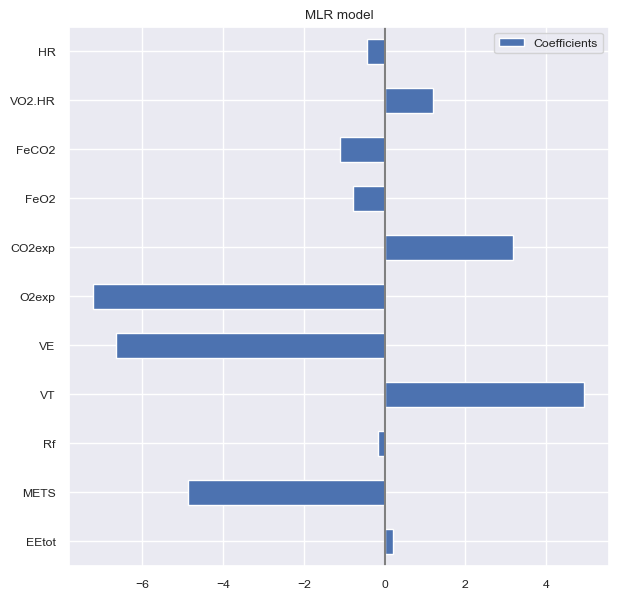

In [552]:
coefs.plot(kind="barh", figsize=(9, 7))
plt.title("MLR model")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Kontrollime kordajate stabiilsust ehk nende varieeruvust mudeli korduval konstrueerimisel:

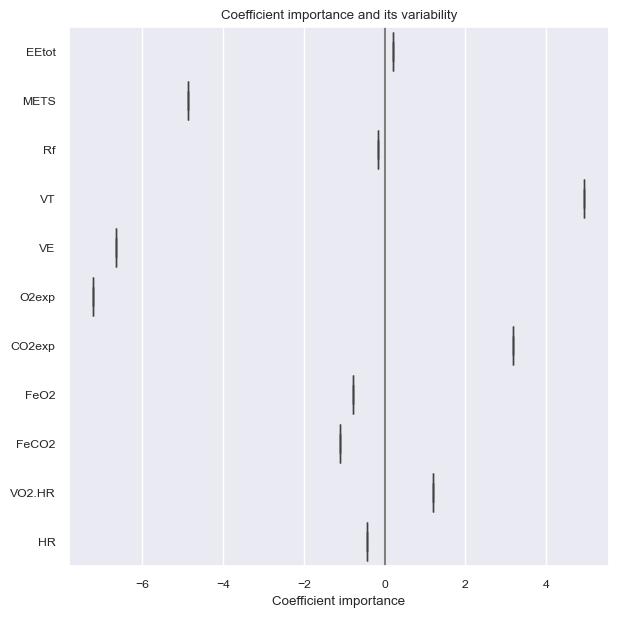

In [553]:
cv_model = cross_validate(
    slr,
    X_train_std,
    y_train,
    cv=10,
    n_jobs=1
)
coefs = pd.DataFrame(
    [slr.coef_ for model in cv_model],
    columns=X.columns,
)
plt.figure(figsize=(9, 7))
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.subplots_adjust(left=0.3)

Kordajad ei ole tasakaalus nullpunkti suhtes. Mitte ühtlane ja kõrge varieeruvus kordajate ümber viitab sellele, et mudel ei ole stabiilne ja kordajad ei ole järjepidevad erinevatel andmestikel mudeli korduval konstrueerimisel.

Leiame lineaarse regressiooni mudeli täpsust ristvalideerimise abil, arvutades keskmise R2 täpsuse ristvalideerimise tulemuste põhjal. Saame eraldi täpsused treening- ja testandmetel.

In [555]:
scores = cross_val_score(estimator=slr,
                         X=X_train_std,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV keskmine R2 täpsus: %.3f' % np.mean(scores), "+/- %.3f" % np.std(scores))
print('R2 täpsus treeningandmetel: %.3f' % slr.score(X_train_std, y_train))
print('R2 täpsus testandmetel: %.3f' % slr.score(X_test_std, y_test))

CV keskmine R2 täpsus: 0.970 +/- 0.001
R2 täpsus treeningandmetel: 0.970
R2 täpsus testandmetel: 0.970


Mudeli RMSE leidmine:

In [556]:
scores = cross_val_score(estimator=slr,
                         X=X_train_std,
                         y=y_train,
                         scoring = 'neg_mean_squared_error',
                         cv=10,
                         n_jobs=1)
print('CV keskmine RMSE: %.3f' % np.mean(np.sqrt(np.abs(scores))), "+/- %.3f" % np.std(np.sqrt(np.abs(scores))))
print('RMSE treeningandmetel: %.3f' % np.sqrt(mean_squared_error(y_train,slr.predict(X_train_std))))
print('RMSE testandmetel: %.3f' % np.sqrt(mean_squared_error(y_test,slr.predict(X_test_std))))

CV keskmine RMSE: 1.808 +/- 0.042
RMSE treeningandmetel: 1.807
RMSE testandmetel: 1.786


Mudeli jäägid ehk vead:

In [557]:
residuals=y_train-slr.predict(X_train_std)

Mudeli standardiseeritud jäägid ehk vead:

In [558]:
std_residuals=residuals/np.std(residuals)

Mudeli diagnostika diagrammid:

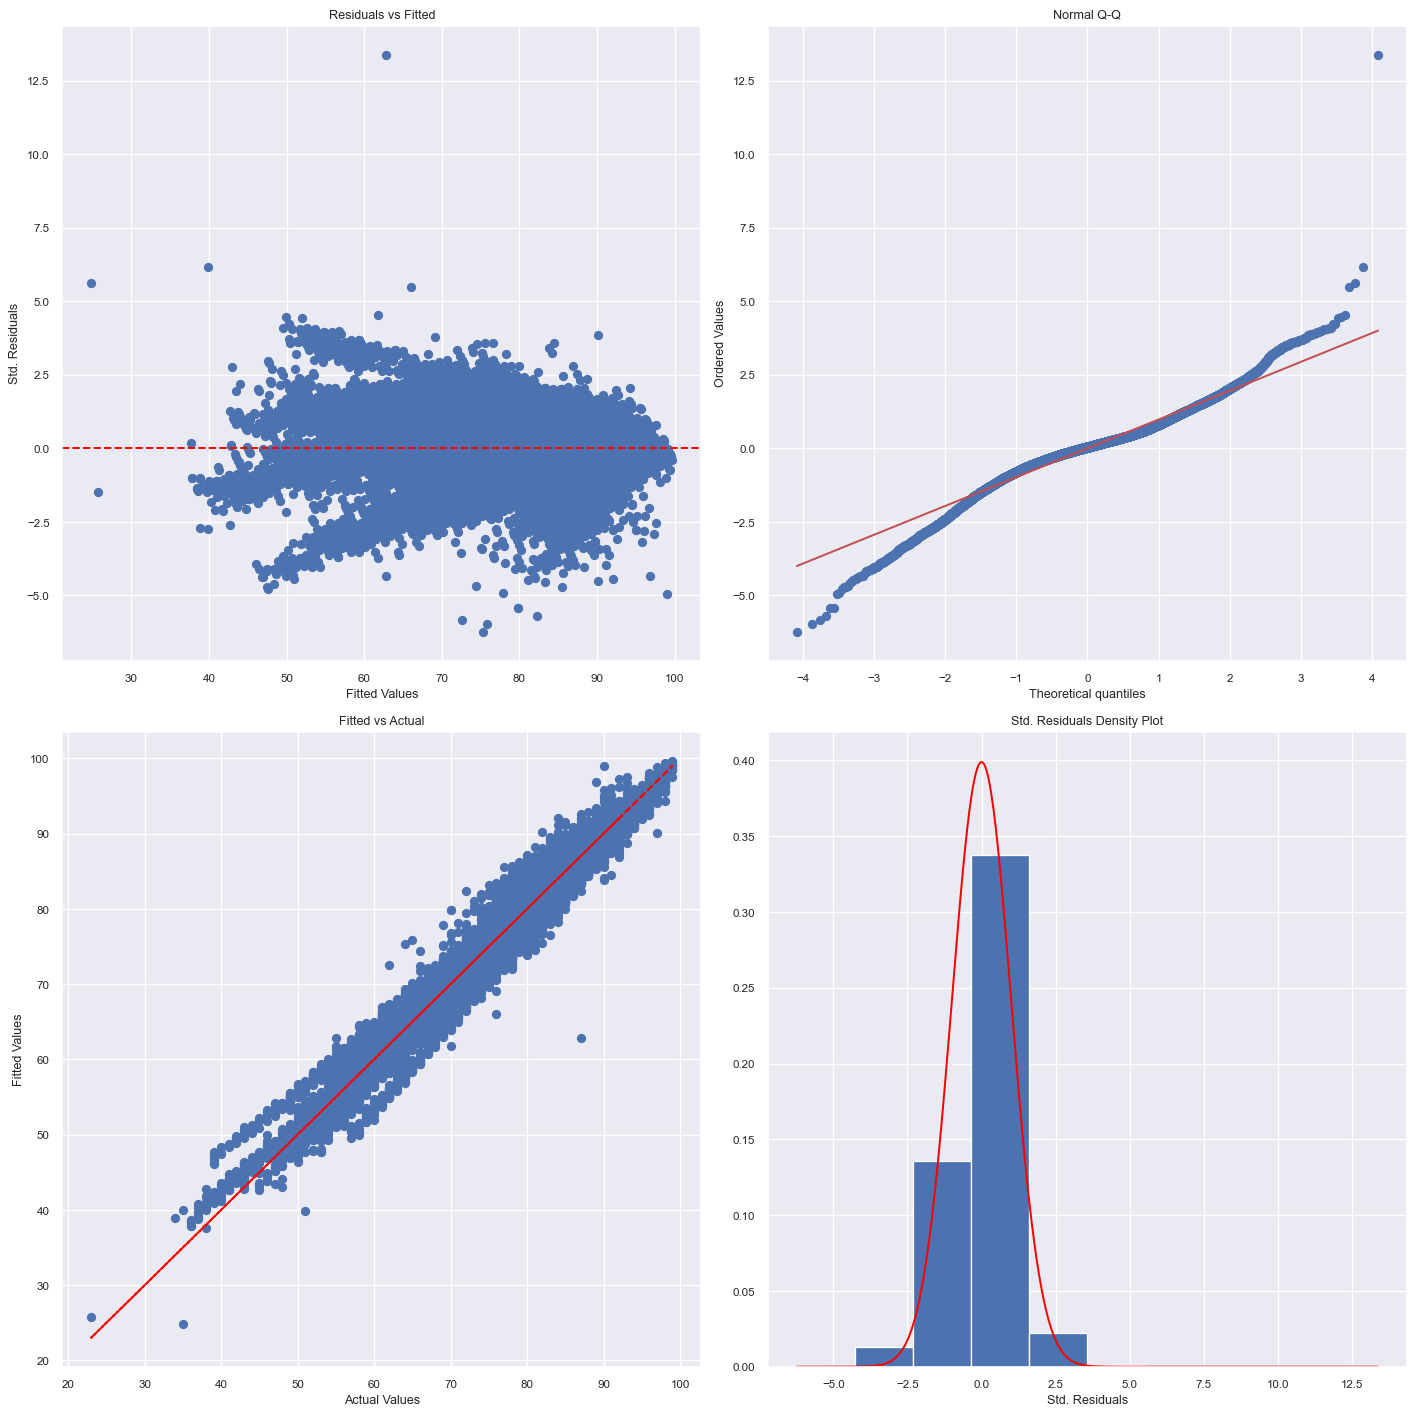

In [559]:
fig, axs = plt.subplots(2,2,dpi=95,figsize=(15,15))
plt.style.use("seaborn-v0_8-whitegrid")
# Residual against fitted values
axs[0, 0].scatter(x=slr.predict(X_train_std), y=std_residuals)
axs[0, 0].axhline(y=0, color='red', linestyle='dashed')
axs[0, 0].set_xlabel('Fitted Values')
axs[0, 0].set_ylabel('Std. Residuals')
axs[0, 0].set_title('Residuals vs Fitted')

# normal qqplot
stats.probplot(std_residuals, plot=axs[0, 1])
#sm.qqplot(std_residuals, dist=stats.t, fit=True, line='45', c='#4C72B0',ax=axs[0, 1])
axs[0, 1].set_title('Normal Q-Q')

# Fitted values against actual values
axs[1, 0].scatter(x=y_train, y=slr.predict(X_train_std))
axs[1, 0].plot(y_train, y_train, color='red', linestyle='dashed')
axs[1, 0].set_xlabel('Actual Values')
axs[1, 0].set_ylabel('Fitted Values')
axs[1, 0].set_title('Fitted vs Actual')

# Histogram of std. residuals
axs[1, 1].hist(std_residuals, density=True)
x = np.linspace(min(std_residuals),max(std_residuals), 500)
axs[1, 1].plot(x, norm.pdf(x),color='red')
axs[1, 1].set_xlabel('Std. Residuals')
axs[1, 1].set_title('Std. Residuals Density Plot')
fig.tight_layout()
plt.show()

Residuals vs Fitted ehk Jäägid vs Prognoosid: punktid ei ole juhuslikult hajutatud x=0 joone ümber. Mõne funktsionaalsuse olemasolu viitab mudeli parandamise võimalusele nt kõrgemate astmetega komponentide lisamise teel.

Sihttunnus Y on vasakpoolse asümmeetriaga. Järelikult, logaritmi teisenduse kasutamine võib olla vähem efektiivne või ebatõhus. Logaritmi teisendus on tavaliselt efektiivne parempoolse asümmeetriaga tunnuste korral, kuna see aitab muuta jaotuse sümmeetrilisemaks. Vasakpoolse asümmeetriaga tunnuste puhul võib logaritmi teisendus aga kaotada olulist teavet või muuta andmed ebatäpselt interpreteeritavaks.

Normal Q-Q ehk kvantiil-kvantiil diagramm: Mida lähedam standardiseeritud jääkide kvantiilid standardse normaaljaotuse kvantiilidele, seda parem.

Actual vs Fitted ehk Tegelikud väärtused vs Prognoosid diagramm: Mudel on piisavalt hästi sobitatud treeningandmetele, kuna punktid paiknevad y=x punase sirgjoone lähedal.

Mudel prognoosib erineva *energy* väärtusega lauausid ühtlaselt.

## Mudel kategooriliste tunnustega

Teisendame kategoorilised tunnused, mis võimaldab neid kasutada mudelis. Teeme uue andmestruktuuri, kus iga kategooriline tunnus on asendatud mitme uue tunnusega, eeldusega, et konkreetne vaatlus vastab selle kategooria jaoks (1). Kõige esimene kategooria jäetud välja, et vältida dummy muutujate omavahelist sõltuvust. Uus andmestruktuur sisaldab kategooriliste tunnuste asendusi dummy muutujatega.

In [560]:
X_dummy = pd.get_dummies(data=df.drop([_SIHTTUNNUS_],axis=1), drop_first=True)
X_dummy.head

<bound method NDFrame.head of         EEtot   METS      Rf     VT      VE    O2exp  CO2exp    FeO2  FeCO2  \
0      0.0000 0.9528 21.5054 0.4091  8.7978  73.1476 12.4463 17.8803 3.0424   
1      0.0097 1.0143 24.5902 0.4642 11.4144  85.4919 11.8342 18.4176 2.5495   
2      0.0940 1.9223 22.5564 0.8774 19.7902 159.3537 25.3007 18.1628 2.8837   
3      0.2080 2.0189 20.0000 0.9243 18.4858 164.5567 30.6057 17.8035 3.3113   
4      0.2703 1.2154 22.0588 0.5876 12.9624 107.3240 16.2210 18.2639 2.7604   
...       ...    ...     ...    ...     ...      ...     ...     ...    ...   
38718 85.4218 1.2031 21.8182 0.5650 12.3281 102.0947 13.8710 18.0686 2.4549   
38719 85.4871 0.9703 19.8675 0.5314 10.5573  96.9951 11.8312 18.2534 2.2265   
38720 85.5828 2.2391 26.7857 0.6436 17.2386 110.4581 19.6846 17.1632 3.0586   
38721 85.7260 1.3556 14.9254 0.7017 10.4733 120.3514 22.2344 17.1512 3.1686   
38722 86.1708 1.4569 24.7934 0.6028 14.9449 109.3362 12.8511 18.1387 2.1320   

       VO2.HR  ...  o

In [561]:
X_dummy

EEtot   METS      Rf     VT      VE    O2exp  CO2exp    FeO2  FeCO2  \
0      0.0000 0.9528 21.5054 0.4091  8.7978  73.1476 12.4463 17.8803 3.0424   
1      0.0097 1.0143 24.5902 0.4642 11.4144  85.4919 11.8342 18.4176 2.5495   
2      0.0940 1.9223 22.5564 0.8774 19.7902 159.3537 25.3007 18.1628 2.8837   
3      0.2080 2.0189 20.0000 0.9243 18.4858 164.5567 30.6057 17.8035 3.3113   
4      0.2703 1.2154 22.0588 0.5876 12.9624 107.3240 16.2210 18.2639 2.7604   
...       ...    ...     ...    ...     ...      ...     ...     ...    ...   
38718 85.4218 1.2031 21.8182 0.5650 12.3281 102.0947 13.8710 18.0686 2.4549   
38719 85.4871 0.9703 19.8675 0.5314 10.5573  96.9951 11.8312 18.2534 2.2265   
38720 85.5828 2.2391 26.7857 0.6436 17.2386 110.4581 19.6846 17.1632 3.0586   
38721 85.7260 1.3556 14.9254 0.7017 10.4733 120.3514 22.2344 17.1512 3.1686   
38722 86.1708 1.4569 24.7934 0.6028 14.9449 109.3362 12.8511 18.1387 2.1320   

       VO2.HR  ...  original_activity_labels_walkingFast  \
0      2.1250  ...                                 False   
1      2.2403  ...                                 False   
2      4.2051  ...                                 False   
3      4.3329  ...                                 False   
4      2.6086  ...                                 False   
...       ...  ...                                   ...   
38718  3.9375  ...                                 False   
38719  3.1757  ...                                 False   
38720  7.3279  ...                                 False   
38721  4.4365  ...                                 False   
38722  4.7681  ...                                 False   

       original_activity_labels_walkingNormal  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                       False   
...                                       ...   
38718                                   False   
38719                                   False   
38720                                   False   
38721                                   False   
38722                                   False   

       original_activity_labels_walkingSlow  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   
...                                     ...   
38718                                 False   
38719                                 False   
38720                                 False   
38721                                 False   
38722                                 False   

       original_activity_labels_walkingStairsUp  \
0                                         False   
1                                         False   
2                                         False   
3                                         False   
4                                         False   
...                                         ...   
38718                                     False   
38719                                     False   
38720                                     False   
38721                                     False   
38722                                     False   

       predicted_activity_label_household  predicted_activity_label_jumping  \
0                                   False                             False   
1                                   False                             False   
2                                   False                             False   
3                                   False                             False   
4                                   False                             False   
...                                   ...                               ...   
38718             

Treening- ja testandmete eraldamine

In [562]:
X_train, X_test, y_train, y_test = train_test_split(X_dummy, y, test_size=0.2, random_state=0)

Andmete standardiseerimine

Standardiseerime arvulised prediktorid ja ühendame neid teiste prediktoritega. Alguses eraldame arvulised tunnused:

In [563]:
X_train_num = X_train[num_f.drop([_SIHTTUNNUS_],axis=1).columns]
X_train_num.head()

EEtot   METS      Rf     VT      VE    O2exp  CO2exp    FeO2  FeCO2  \
7985  120.9925 1.0065  9.9834 1.2768 12.7465 232.7153 31.6134 18.2268 2.4760   
16281 144.2626 3.4369 31.4136 0.9985 31.3650 174.7038 35.1855 17.4974 3.5240   
9594  103.5986 1.5816 18.2927 0.9607 17.5744 167.2611 29.5767 17.4098 3.0786   
9242   51.8238 2.3240 26.6667 0.9985 26.6258 174.7062 30.6985 17.4974 3.0746   
17936 129.4891 7.6673 32.2581 1.6683 53.8148 286.4388 65.4659 17.1699 3.9242   

       VO2.HR   HR  
7985   4.6235   64  
16281  6.5937  135  
9594   7.8152   68  
9242  11.8315   66  
17936  0.0000    0

In [564]:
X_test_num = X_test[num_f.drop([_SIHTTUNNUS_],axis=1).columns]
X_test_num.head()

EEtot   METS      Rf     VT      VE    O2exp  CO2exp    FeO2  FeCO2  \
14331  60.2944 1.5900 22.3048 0.6506 14.5125 113.0974 16.8269 17.3824 2.5862   
3717  118.9672 3.1380 28.3019 1.1517 32.5956 197.4944 43.9670 17.1479 3.8175   
6326   46.2270 1.5039 22.1402 0.7110 15.7408 126.2795 19.9925 17.7618 2.8121   
33591  99.7225 1.6865 18.8679 0.8608 16.2412 153.3907 22.7434 17.8199 2.6422   
9741  129.1196 1.5356 20.6897 0.9097 18.8221 161.0398 27.0269 17.7018 2.9709   

       VO2.HR  HR  
14331  6.3275  73  
3717  10.5206  95  
6326   5.6145  75  
33591  5.6727  77  
9741   7.2668  71

Standardiseerimine:

In [565]:
sc.fit(X_train_num)
X_train_std = sc.transform(X_train_num)
X_test_std = sc.transform(X_test_num)

Ühendame prediktoreid:

In [566]:
X_train_num.columns

Index(['EEtot', 'METS', 'Rf', 'VT', 'VE', 'O2exp', 'CO2exp', 'FeO2', 'FeCO2',
       'VO2.HR', 'HR'],
      dtype='object')

In [567]:
X_train.columns

Index(['EEtot', 'METS', 'Rf', 'VT', 'VE', 'O2exp', 'CO2exp', 'FeO2', 'FeCO2',
       'VO2.HR', 'HR', 'gender_male', 'original_activity_labels_dishwashing',
       'original_activity_labels_lyingDownLeft',
       'original_activity_labels_lyingDownRight',
       'original_activity_labels_sittingChair',
       'original_activity_labels_sittingCouch',
       'original_activity_labels_sittingSofa',
       'original_activity_labels_stakingShelves',
       'original_activity_labels_standing', 'original_activity_labels_step',
       'original_activity_labels_syncJumping',
       'original_activity_labels_vacuumCleaning',
       'original_activity_labels_walkingFast',
       'original_activity_labels_walkingNormal',
       'original_activity_labels_walkingSlow',
       'original_activity_labels_walkingStairsUp',
       'predicted_activity_label_household',
       'predicted_activity_label_jumping',
       'predicted_activity_label_lyingDown',
       'predicted_activity_label_sitting', 'predict

In [569]:
dummy_col=X_train.columns[~X_train.columns.isin(X_train_num.columns)]
dummy_col

Index(['gender_male', 'original_activity_labels_dishwashing',
       'original_activity_labels_lyingDownLeft',
       'original_activity_labels_lyingDownRight',
       'original_activity_labels_sittingChair',
       'original_activity_labels_sittingCouch',
       'original_activity_labels_sittingSofa',
       'original_activity_labels_stakingShelves',
       'original_activity_labels_standing', 'original_activity_labels_step',
       'original_activity_labels_syncJumping',
       'original_activity_labels_vacuumCleaning',
       'original_activity_labels_walkingFast',
       'original_activity_labels_walkingNormal',
       'original_activity_labels_walkingSlow',
       'original_activity_labels_walkingStairsUp',
       'predicted_activity_label_household',
       'predicted_activity_label_jumping',
       'predicted_activity_label_lyingDown',
       'predicted_activity_label_sitting', 'predicted_activity_label_standing',
       'predicted_activity_label_walking'],
      dtype='object')

In [570]:
X_train_std=pd.DataFrame(X_train_std, columns=X_train_num.columns).join(X_train[dummy_col].reset_index()).drop(['index'],axis=1)
X_train_std.head()

EEtot    METS      Rf      VT      VE   O2exp  CO2exp    FeO2   FeCO2  \
0  0.9165 -1.0224 -1.3076  0.1345 -0.8833  0.2415 -0.3129  0.9779 -0.9337   
1  1.3635  0.3213  0.6981 -0.3264  0.2122 -0.3180 -0.1632  0.0106  0.6142   
2  0.5823 -0.7044 -0.5299 -0.3889 -0.5992 -0.3898 -0.3982 -0.1057 -0.0438   
3 -0.4122 -0.2940  0.2538 -0.3264 -0.0667 -0.3180 -0.3512  0.0106 -0.0497   
4  1.0797  2.6602  0.7772  0.7827  1.5331  0.7596  1.1058 -0.4238  1.2053   

   VO2.HR  ...  original_activity_labels_walkingFast  \
0 -0.6636  ...                                 False   
1 -0.2686  ...                                 False   
2 -0.0237  ...                                 False   
3  0.7816  ...                                 False   
4 -1.5906  ...                                 False   

   original_activity_labels_walkingNormal  \
0                                   False   
1                                   False   
2                                   False   
3                                   False   
4                                   False   

   original_activity_labels_walkingSlow  \
0                                 False   
1                                 False   
2                                 False   
3                                 False   
4                                 False   

   original_activity_labels_walkingStairsUp  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   

   predicted_activity_label_household  predicted_activity_label_jumping  \
0                               False                             False   
1                               False                             False   
2                               False                             False   
3                               False                             False   
4                               False                             False   

   predicted_activity_label_lyingDown  predicted_activity_label_sitting  \
0                               False                             False   
1                               False                             False   
2                               False                             False   
3                               False                              True   
4                               False                             False   

   predicted_activity_label_standing  predicted_activity_label_walking  
0                               True                             False  
1                              False                             False  
2                              False                             False  
3                              False                             False  
4                              False                             False  

[5 rows x 33 columns]

In [571]:
X_test_std=pd.DataFrame(X_test_std, columns=X_test_num.columns).join(X_test[dummy_col].reset_index()).drop(['index'],axis=1)
X_test_std.head()

EEtot    METS      Rf      VT      VE   O2exp  CO2exp    FeO2   FeCO2  \
0 -0.2495 -0.6998 -0.1544 -0.9023 -0.7794 -0.9122 -0.9325 -0.1420 -0.7710   
1  0.8776  0.1560  0.4069 -0.0726  0.2846 -0.0982  0.2048 -0.4530  1.0478   
2 -0.5197 -0.7474 -0.1698 -0.8025 -0.7071 -0.7851 -0.7999  0.3612 -0.4374   
3  0.5079 -0.6465 -0.4761 -0.5544 -0.6777 -0.5236 -0.6846  0.4382 -0.6883   
4  1.0726 -0.7299 -0.3056 -0.4733 -0.5258 -0.4498 -0.5051  0.2816 -0.2029   

   VO2.HR  ...  original_activity_labels_walkingFast  \
0 -0.3220  ...                                 False   
1  0.5188  ...                                 False   
2 -0.4649  ...                                 False   
3 -0.4532  ...                                 False   
4 -0.1336  ...                                 False   

   original_activity_labels_walkingNormal  \
0                                   False   
1                                   False   
2                                   False   
3                                   False   
4                                   False   

   original_activity_labels_walkingSlow  \
0                                 False   
1                                 False   
2                                 False   
3                                 False   
4                                 False   

   original_activity_labels_walkingStairsUp  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   

   predicted_activity_label_household  predicted_activity_label_jumping  \
0                               False                             False   
1                               False                             False   
2                               False                             False   
3                               False                             False   
4                               False                             False   

   predicted_activity_label_lyingDown  predicted_activity_label_sitting  \
0                               False                             False   
1                               False                             False   
2                               False                             False   
3                               False                             False   
4                               False                             False   

   predicted_activity_label_standing  predicted_activity_label_walking  
0                               True                             False  
1                              False                             False  
2                              False                             False  
3                              False                             False  
4                              False                             False  

[5 rows x 33 columns]

In [572]:
X_train_std.describe().T

count    mean    std     min     25%     50%    75%     max
EEtot  30956.0000 -0.0000 1.0000 -1.4077 -0.7433 -0.1782 0.5320  4.1906
METS   30956.0000  0.0000 1.0000 -1.5789 -0.7663 -0.2625 0.5628  6.8422
Rf     30956.0000 -0.0000 1.0000 -1.9714 -0.5403 -0.1544 0.3578 32.8557
VT     30956.0000 -0.0000 1.0000 -1.9071 -0.7096 -0.1964 0.5062  5.6983
VE     30956.0000 -0.0000 1.0000 -1.6217 -0.7266 -0.2861 0.4337  6.1408
O2exp  30956.0000  0.0000 1.0000 -1.9263 -0.7007 -0.2029 0.4874  7.3464
CO2exp 30956.0000  0.0000 1.0000 -1.6377 -0.7359 -0.2141 0.5081  5.3928
FeO2   30956.0000 -0.0000 1.0000 -6.2942 -0.5822  0.0304 0.5923  6.5488
FeCO2  30956.0000  0.0000 1.0000 -4.5911 -0.6006 -0.0221 0.6297  4.4391
VO2.HR 30956.0000  0.0000 1.0000 -1.5906 -0.6696 -0.0786 0.6387  5.4592
HR     30956.0000 -0.0000 1.0000 -2.2608 -0.3523  0.0350 0.6158  3.3541

Mudeli loomine

In [573]:
slr = LinearRegression()

slr.fit(X_train_std, y_train)

LinearRegression()

Mudeli testimine

In [574]:
for col_name, x_i in zip(X_train_std.columns, slr.coef_):
    print(col_name  + "\t", round(x_i, 4))

EEtot	 0.3427
METS	 -3.5948
Rf	 -0.1438
VT	 -1.9174
VE	 -7.7364
O2exp	 -1.0871
CO2exp	 3.6944
FeO2	 -0.8997
FeCO2	 -1.1319
VO2.HR	 1.0267
HR	 -0.431
gender_male	 1.689
original_activity_labels_dishwashing	 -0.0086
original_activity_labels_lyingDownLeft	 -0.081
original_activity_labels_lyingDownRight	 0.1272
original_activity_labels_sittingChair	 0.1404
original_activity_labels_sittingCouch	 0.29
original_activity_labels_sittingSofa	 0.3322
original_activity_labels_stakingShelves	 -0.0734
original_activity_labels_standing	 0.6567
original_activity_labels_step	 0.5285
original_activity_labels_syncJumping	 0.8112
original_activity_labels_vacuumCleaning	 -0.1988
original_activity_labels_walkingFast	 0.2011
original_activity_labels_walkingNormal	 0.4773
original_activity_labels_walkingSlow	 0.6735
original_activity_labels_walkingStairsUp	 0.2222
predicted_activity_label_household	 -0.084
predicted_activity_label_jumping	 0.4172
predicted_activity_label_lyingDown	 0.005
predicted_activity_la

In [575]:
coefs = pd.DataFrame(
    slr.coef_, columns=["Coefficients"], index=X_train_std.columns)
coefs

Coefficients
EEtot                                           0.3427
METS                                           -3.5948
Rf                                             -0.1438
VT                                             -1.9174
VE                                             -7.7364
O2exp                                          -1.0871
CO2exp                                          3.6944
FeO2                                           -0.8997
FeCO2                                          -1.1319
VO2.HR                                          1.0267
HR                                             -0.4310
gender_male                                     1.6890
original_activity_labels_dishwashing           -0.0086
original_activity_labels_lyingDownLeft         -0.0810
original_activity_labels_lyingDownRight         0.1272
original_activity_labels_sittingChair           0.1404
original_activity_labels_sittingCouch           0.2900
original_activity_labels_sittingSofa            0.3322
original_activity_labels_stakingShelves        -0.0734
original_activity_labels_standing               0.6567
original_activity_labels_step                   0.5285
original_activity_labels_syncJumping            0.8112
original_activity_labels_vacuumCleaning        -0.1988
original_activity_labels_walkingFast            0.2011
original_activity_labels_walkingNormal          0.4773
original_activity_labels_walkingSlow            0.6735
original_activity_labels_walkingStairsUp        0.2222
predicted_activity_label_household             -0.0840
predicted_activity_label_jumping                0.4172
predicted_activity_label_lyingDown              0.0050
predicted_activity_label_sitting               -0.0274
predicted_activity_label_standing               0.1396
predicted_activity_label_walking               -0.1832

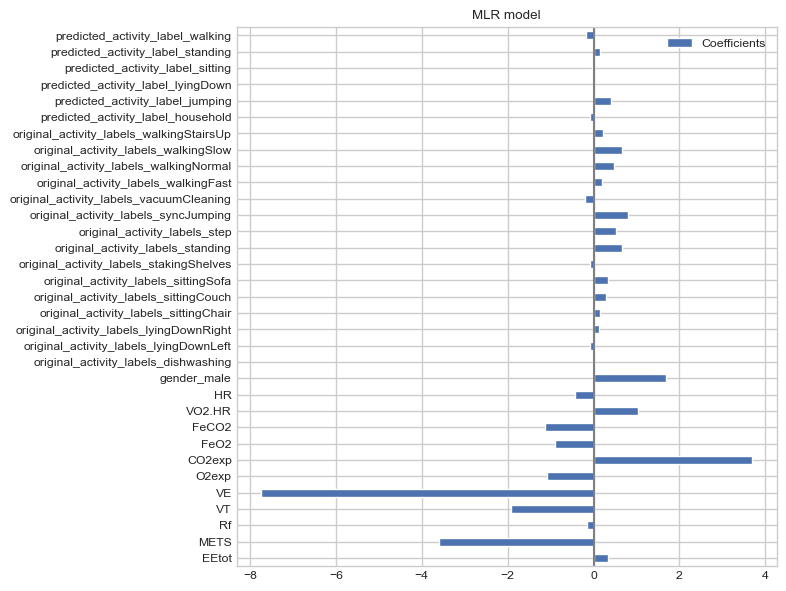

In [576]:
coefs.plot(kind="barh", figsize=(9, 7))
plt.title("MLR model")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Kõige kõrgema mõjuga koefitsiendid on:
* lFKHJJF

Teeme ristvalideerimist mudeli täpsuse hindamiseks ja hindame mudeli keskmise täpsuse 10 erineva ristvalideerimise iteratsiooni põhjal.

In [577]:
scores = cross_val_score(estimator=slr,
                         X=X_train_std,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV keskmine R2 täpsus: %.3f' % np.mean(scores), "+/- %.3f" % np.std(scores))
print('R2 täpsus treeningandmetel: %.3f' % slr.score(X_train_std, y_train))
print('R2 täpsus testandmetel: %.3f' % slr.score(X_test_std, y_test))

CV keskmine R2 täpsus: 0.974 +/- 0.001
R2 täpsus treeningandmetel: 0.974
R2 täpsus testandmetel: 0.974


Arvutame lineaarse regressiooni mudeli RMSE treeningandmetel, kasutades *mean_squared_error* funktsiooni, et saada RMSE treeningandmetel ja seejärel võtta sellest ruutjuur. See annab hinnangu sellele, kui hästi mudel ennustab treeningandmeid.

In [578]:
scores = cross_val_score(estimator=slr,
                         X=X_train_std,
                         y=y_train,
                         scoring = 'neg_mean_squared_error',
                         cv=10,
                         n_jobs=1)
print('CV keskmine RMSE: %.3f' % np.mean(np.sqrt(np.abs(scores))), "+/- %.3f" % np.std(np.sqrt(np.abs(scores))))
print('RMSE treeningandmetel: %.3f' % np.sqrt(mean_squared_error(y_train,slr.predict(X_train_std))))
print('RMSE testandmetel: %.3f' % np.sqrt(mean_squared_error(y_test,slr.predict(X_test_std))))

CV keskmine RMSE: 1.673 +/- 0.035
RMSE treeningandmetel: 1.670
RMSE testandmetel: 1.652


Mudeli jäägid ehk vead:

In [579]:
residuals=y_train-slr.predict(X_train_std)

Mudeli standardiseeritud jäägid ehk vead:

In [580]:
std_residuals=residuals/np.std(residuals)

Mudeli diagnostika graafikud:

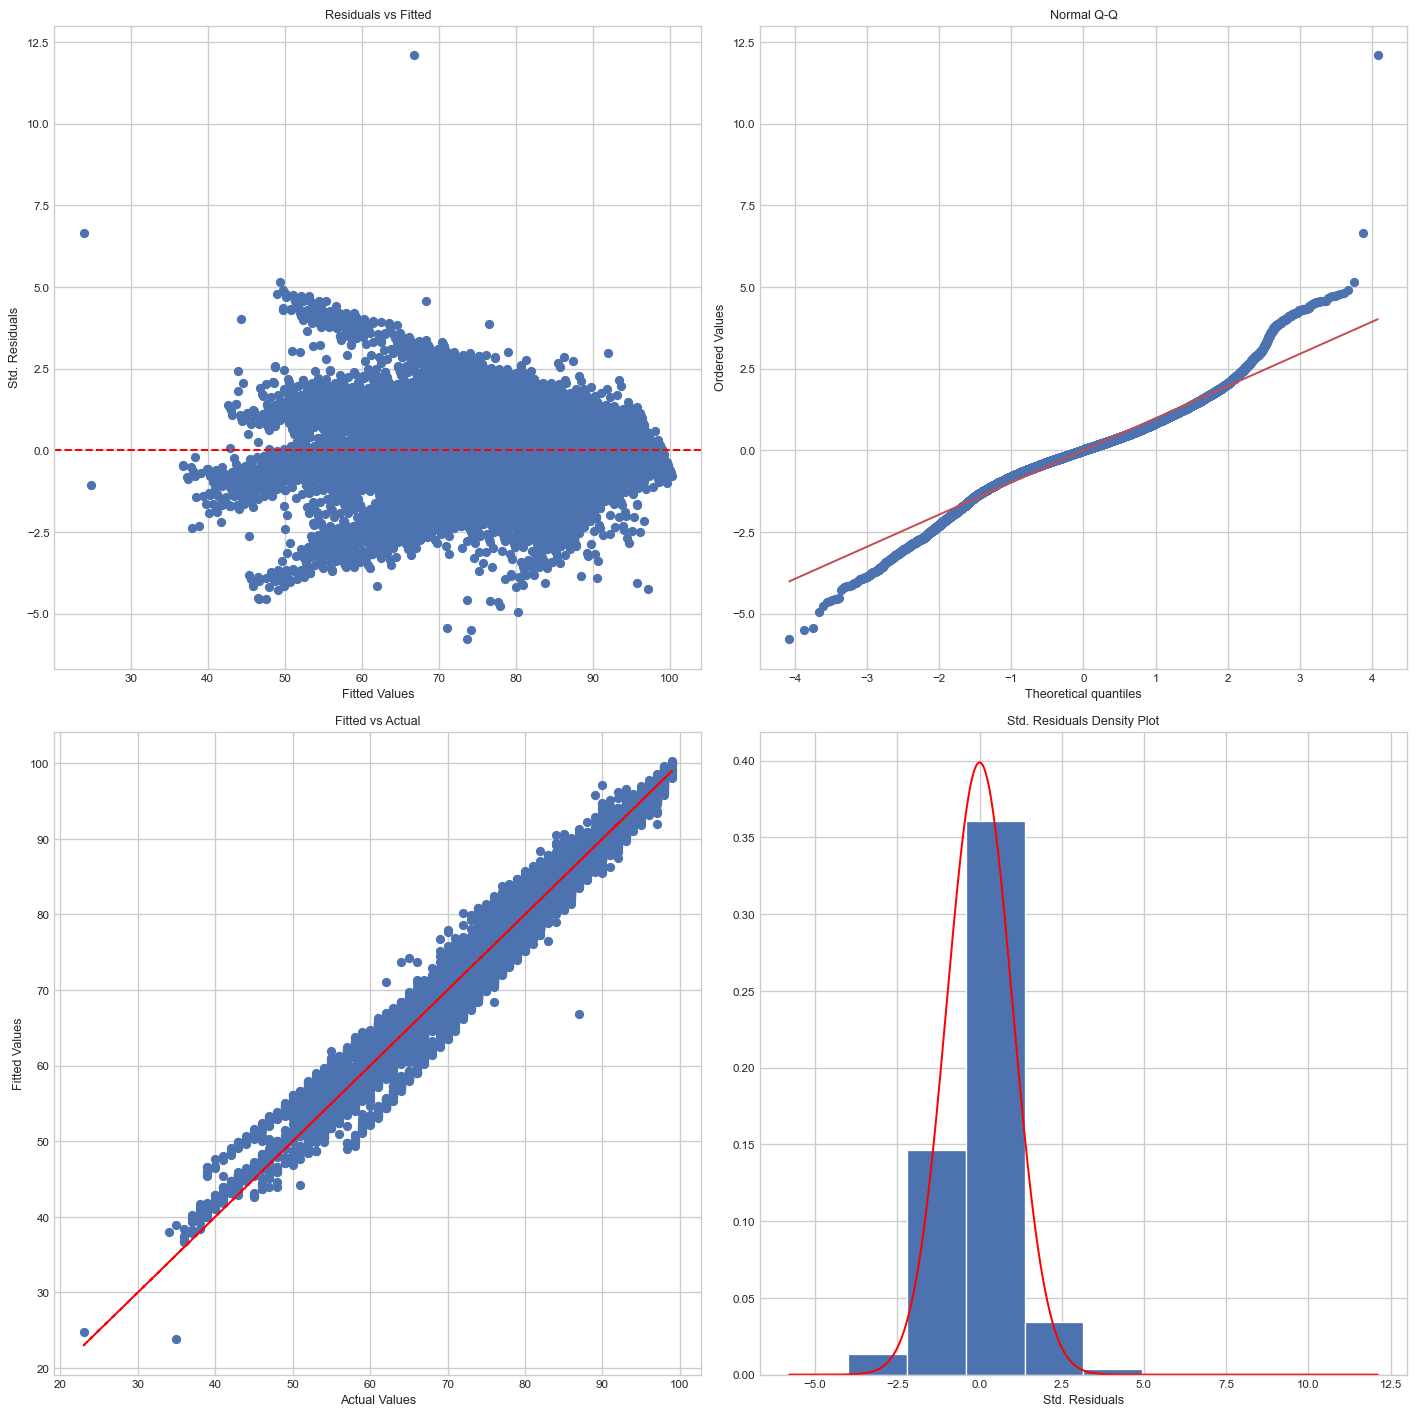

In [581]:
fig, axs = plt.subplots(2,2,dpi=95,figsize=(15,15))
plt.style.use("seaborn-v0_8-whitegrid")
# Residual against fitted values
axs[0, 0].scatter(x=slr.predict(X_train_std), y=std_residuals)
axs[0, 0].axhline(y=0, color='red', linestyle='dashed')
axs[0, 0].set_xlabel('Fitted Values')
axs[0, 0].set_ylabel('Std. Residuals')
axs[0, 0].set_title('Residuals vs Fitted')

# normal qqplot
stats.probplot(std_residuals, plot=axs[0, 1])
#sm.qqplot(std_residuals, dist=stats.t, fit=True, line='45', c='#4C72B0',ax=axs[0, 1])
axs[0, 1].set_title('Normal Q-Q')

# Fitted values against actual values
axs[1, 0].scatter(x=y_train, y=slr.predict(X_train_std))
axs[1, 0].plot(y_train, y_train, color='red', linestyle='dashed')
axs[1, 0].set_xlabel('Actual Values')
axs[1, 0].set_ylabel('Fitted Values')
axs[1, 0].set_title('Fitted vs Actual')

# Histogram of std. residuals
axs[1, 1].hist(std_residuals, density=True)
x = np.linspace(min(std_residuals),max(std_residuals), 500)
axs[1, 1].plot(x, norm.pdf(x),color='red')
axs[1, 1].set_xlabel('Std. Residuals')
axs[1, 1].set_title('Std. Residuals Density Plot')
fig.tight_layout()
plt.show()

Diagnostika diagrammid näitavad sarnased tulemused Lineaarregressiooni mudeliga.

# Polünomiaalregressioon

## Andmete ettevalmistamine

Treening- ja testandmete eraldamine

In [582]:
X = df.drop([_SIHTTUNNUS_],axis=1)
y = df[_SIHTTUNNUS_]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Eraldame kategoorilised ja numbrilised muutujad, kasutades nende identifitseerimiseks nende andmetüüpe. Nagu nägime eelnevalt, objekt vastab kategoorilistele veergudele. Kasutame vastavate veergude valimiseks *make_column_selector*.

In [583]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

numerical_columns

['EEtot',
 'METS',
 'Rf',
 'VT',
 'VE',
 'O2exp',
 'CO2exp',
 'FeO2',
 'FeCO2',
 'VO2.HR',
 'HR']

In [584]:
categorical_columns

['gender', 'original_activity_labels', 'predicted_activity_label']

In [585]:
categorical_preprocessor = OneHotEncoder(drop='first')

Eelprtsessor numbriliste tunnuste jaoks peab sisaldama ka polünoommudeli astmed, seega kasutame konveieri:

In [586]:
numerical_preprocessor = StandardScaler()
numerical_preprocessor = Pipeline([
    ('scaler', StandardScaler()),
    ('poly2', PolynomialFeatures(degree=2))
])

Nüüd loome ColumnTransfomer ja seostame eelprotsessorid vastavate veergudega:

In [587]:
preprocessor = ColumnTransformer(
    [
        ("ctg", categorical_preprocessor, categorical_columns),
        ("num", numerical_preprocessor, numerical_columns),
    ]
)

Nüüd loome konveieri (pipeline), mis ühendab ColumnTransformer mudeliga:

In [588]:
poly_lr = Pipeline([
    ('pre', preprocessor),
    ('lr', LinearRegression())
])

## Mudeli loomine treeningandmetel

In [589]:
poly_lr.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('ctg',
                                                  OneHotEncoder(drop='first'),
                                                  ['gender',
                                                   'original_activity_labels',
                                                   'predicted_activity_label']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly2',
                                                                   PolynomialFeatures())]),
                                                  ['EEtot', 'METS', 'Rf', 'VT',
                                                   'VE', 'O2exp', 'CO2exp',
                                                   'FeO2', 'FeCO2', 'VO2.HR',
                                                   'HR'])])),
                ('lr', LinearRegression())])

Mudeli testimine

In [590]:
preprocessor.get_feature_names_out()

array(['ctg__gender_male', 'ctg__original_activity_labels_dishwashing',
       'ctg__original_activity_labels_lyingDownLeft',
       'ctg__original_activity_labels_lyingDownRight',
       'ctg__original_activity_labels_sittingChair',
       'ctg__original_activity_labels_sittingCouch',
       'ctg__original_activity_labels_sittingSofa',
       'ctg__original_activity_labels_stakingShelves',
       'ctg__original_activity_labels_standing',
       'ctg__original_activity_labels_step',
       'ctg__original_activity_labels_syncJumping',
       'ctg__original_activity_labels_vacuumCleaning',
       'ctg__original_activity_labels_walkingFast',
       'ctg__original_activity_labels_walkingNormal',
       'ctg__original_activity_labels_walkingSlow',
       'ctg__original_activity_labels_walkingStairsUp',
       'ctg__original_activity_labels_nan',
       'ctg__predicted_activity_label_household',
       'ctg__predicted_activity_label_jumping',
       'ctg__predicted_activity_label_lyingDown',

In [591]:
poly_lr.named_steps['lr'].coef_

array([ 1.11760224e+00, -4.50700413e-02, -6.67357094e-02, -1.72668522e-01,
       -8.52312069e-02, -4.10413277e-02, -1.51873493e-01,  9.99639259e-02,
        2.48654698e-01, -1.10626305e-01,  2.04066308e-01, -1.38769294e-02,
       -5.53989815e-02, -8.87848778e-03,  1.57185413e-01, -6.47352462e-02,
       -8.68664288e-02,  6.44397263e-02,  2.26581491e-01,  2.35873750e-02,
        1.82492786e-02,  1.51614556e-01, -5.04442765e-02,  7.38234217e-02,
        9.29414353e+02,  6.37207693e-02, -6.10121398e+00,  2.43782158e+08,
       -3.59527266e+08, -1.50335222e+08,  3.58324677e+08,  1.55690522e+08,
       -5.39760534e+07, -2.99591627e+07,  7.29904349e+00,  4.56559393e+00,
        1.16338283e-02, -3.54117703e-01, -2.89121270e-02, -1.11925969e+00,
        5.69516800e-01,  7.33293727e-01,  3.87844966e-01, -6.24539601e-02,
       -3.56934145e-02, -1.37191646e-01, -9.54688191e-02, -7.28058711e-01,
        1.62009746e-01,  2.74458089e+01,  2.31889782e+00, -1.95547580e+01,
       -6.76481583e+00, -

In [592]:
coefs = pd.DataFrame(
    poly_lr.named_steps['lr'].coef_, columns=["Coefficients"], index=preprocessor.get_feature_names_out())
coefs

Coefficients
ctg__gender_male                                    1.1176
ctg__original_activity_labels_dishwashing          -0.0451
ctg__original_activity_labels_lyingDownLeft        -0.0667
ctg__original_activity_labels_lyingDownRight       -0.1727
ctg__original_activity_labels_sittingChair         -0.0852
...                                                    ...
num__FeCO2 VO2.HR                                   0.3567
num__FeCO2 HR                                      -0.2144
num__VO2.HR^2                                       0.8288
num__VO2.HR HR                                      5.1992
num__HR^2                                           0.4292

[102 rows x 1 columns]

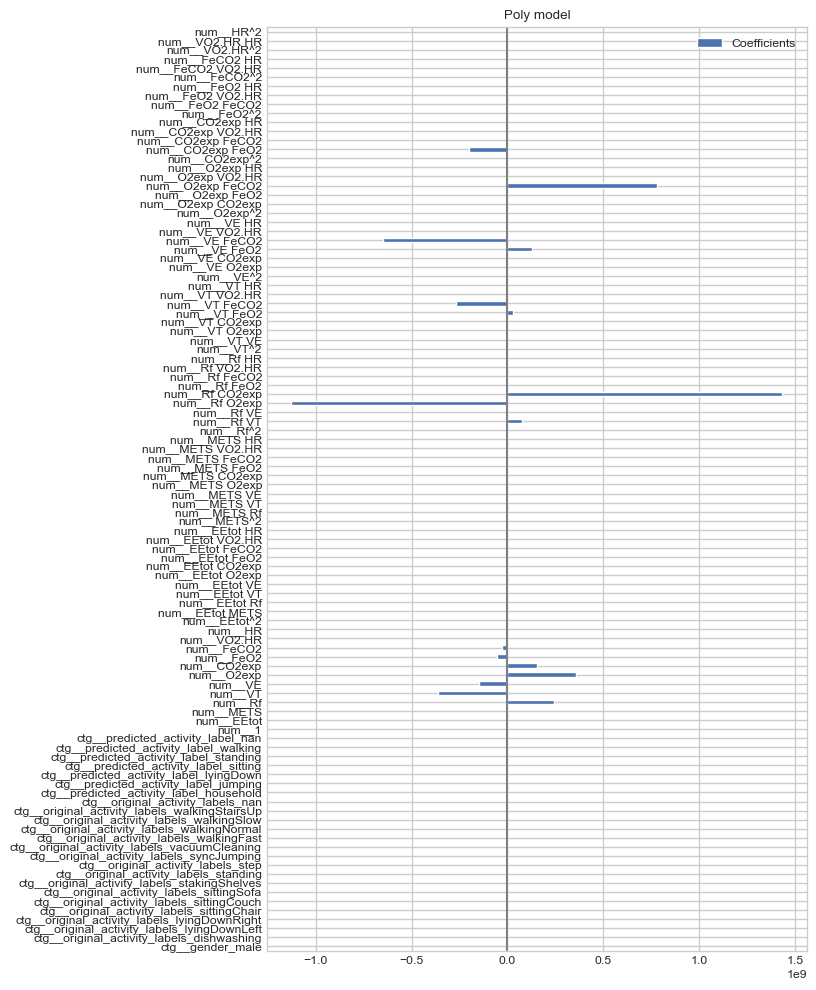

In [593]:
coefs.plot(kind="barh", figsize=(9, 12))
plt.title("Poly model")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [594]:
scores = cross_val_score(estimator=poly_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV keskmine R2 täpsus: %.3f' % np.mean(scores), "+/- %.3f" % np.std(scores))
print('Keskmine R2 täpsus treeningandmetel: %.3f' % poly_lr.score(X_train, y_train))
print('Keskmine R2 täpsus testandmetel: %.3f' % poly_lr.score(X_test, y_test))

CV keskmine R2 täpsus: 0.984 +/- 0.001
Keskmine R2 täpsus treeningandmetel: 0.985
Keskmine R2 täpsus testandmetel: 0.984


Mudeli RMSE leidmine:

In [595]:
scores = cross_val_score(estimator=poly_lr,
                         X=X_train,
                         y=y_train,
                         scoring = 'neg_mean_squared_error',
                         cv=10,
                         n_jobs=1)
print('CV keskmine RMSE: %.3f' % np.mean(np.sqrt(np.abs(scores))), "+/- %.3f" % np.std(np.sqrt(np.abs(scores))))
print('RMSE treeningandmetel: %.3f' % np.sqrt(mean_squared_error(y_train,poly_lr.predict(X_train))))
print('RMSE testandmetel: %.3f' % np.sqrt(mean_squared_error(y_test,poly_lr.predict(X_test))))

CV keskmine RMSE: 1.309 +/- 0.029
RMSE treeningandmetel: 1.299
RMSE testandmetel: 1.289


Mudeli jäägid ehk vead:

In [596]:
residuals=y_train-poly_lr.predict(X_train)

Mudeli standardiseeritud jäägid ehk vead:

In [597]:
std_residuals=residuals/np.std(residuals)

Mudeli diagnostika graafikud:

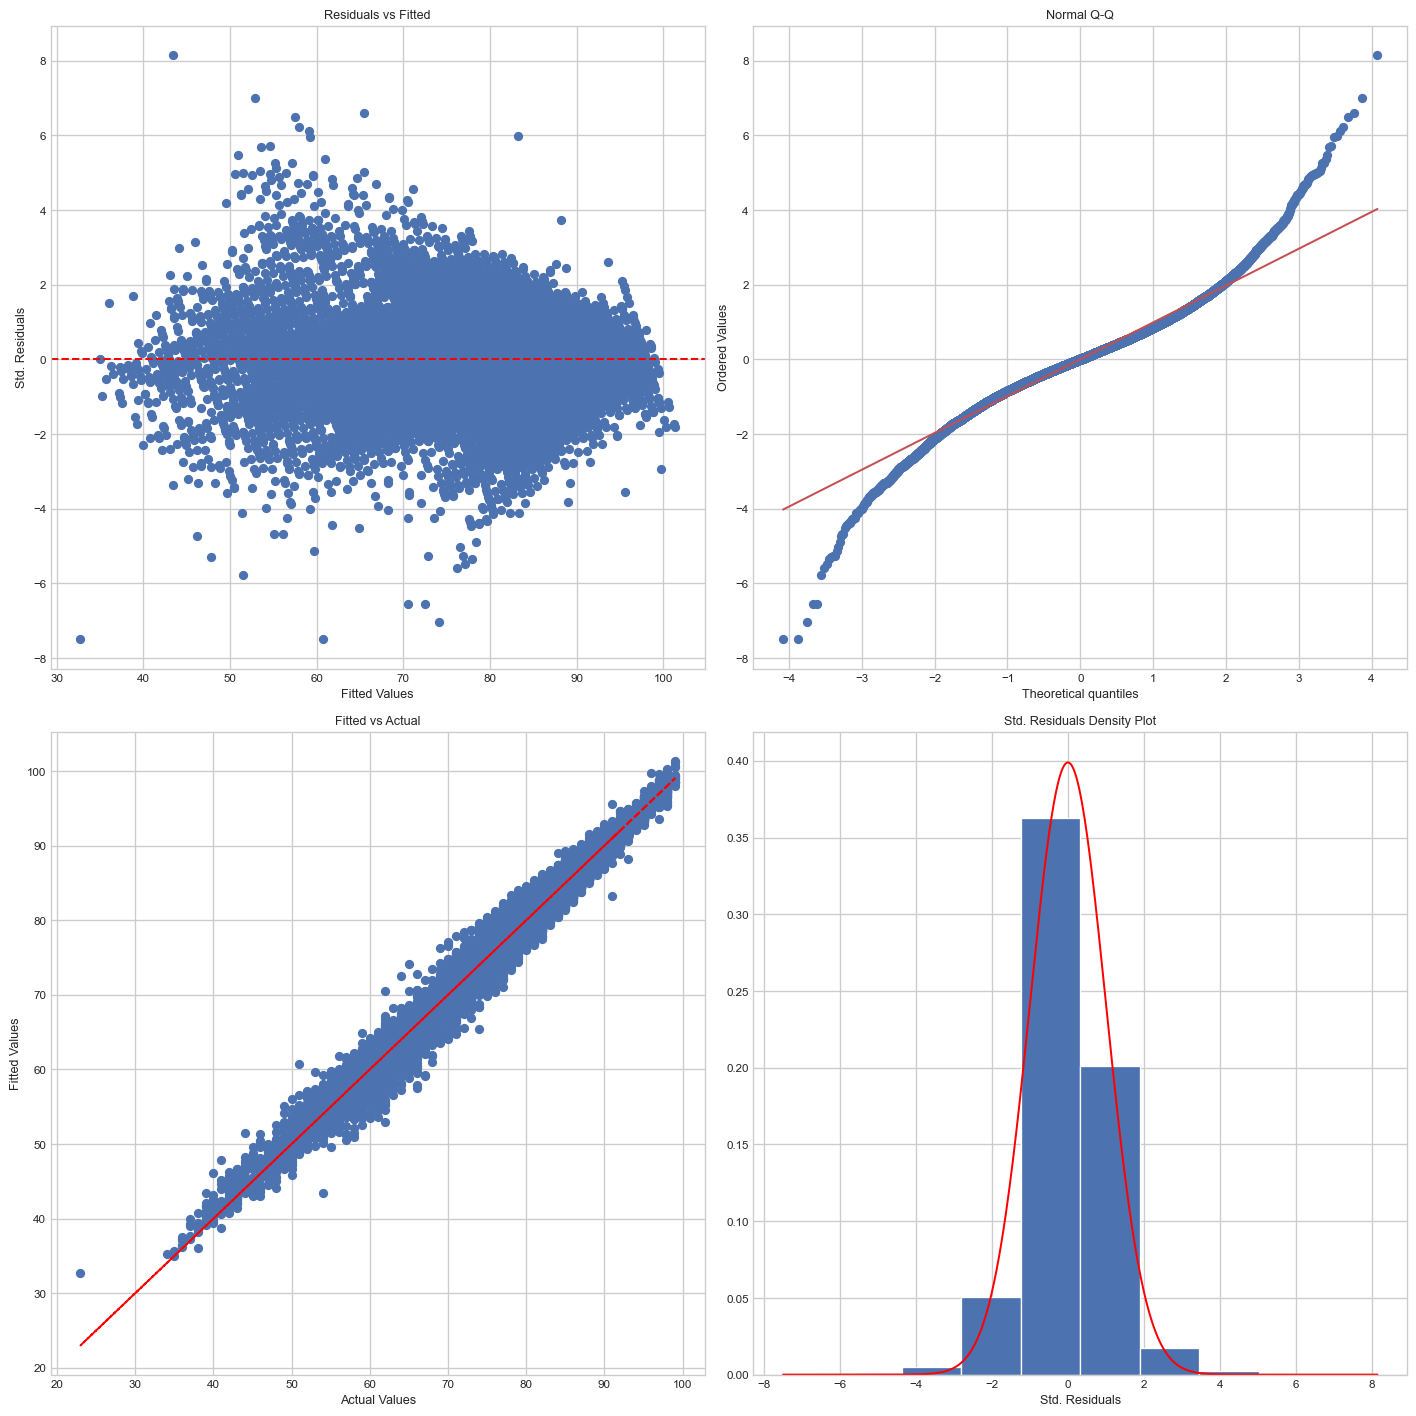

In [598]:
fig, axs = plt.subplots(2,2,dpi=95,figsize=(15,15))
# plt.style.use('seaborn')
# Residual against fitted values
axs[0, 0].scatter(x=poly_lr.predict(X_train), y=std_residuals)
axs[0, 0].axhline(y=0, color='red', linestyle='dashed')
axs[0, 0].set_xlabel('Fitted Values')
axs[0, 0].set_ylabel('Std. Residuals')
axs[0, 0].set_title('Residuals vs Fitted')

# normal qqplot
stats.probplot(std_residuals, plot=axs[0, 1])
#sm.qqplot(std_residuals, dist=stats.t, fit=True, line='45', c='#4C72B0',ax=axs[0, 1])
axs[0, 1].set_title('Normal Q-Q')

# Fitted values against actual values
axs[1, 0].scatter(x=y_train, y=poly_lr.predict(X_train))
axs[1, 0].plot(y_train, y_train, color='red', linestyle='dashed')
axs[1, 0].set_xlabel('Actual Values')
axs[1, 0].set_ylabel('Fitted Values')
axs[1, 0].set_title('Fitted vs Actual')

# Histogram of std. residuals
axs[1, 1].hist(std_residuals, density=True)
x = np.linspace(min(std_residuals),max(std_residuals), 500)
axs[1, 1].plot(x, norm.pdf(x),color='red')
axs[1, 1].set_xlabel('Std. Residuals')
axs[1, 1].set_title('Std. Residuals Density Plot')
fig.tight_layout()
plt.show()

Jääkide diagnostika näitab paremaid tulemusi, kui lineaarregressiooni mudelil.

## Polünomiaalregressiooni astme validatsioonikõver

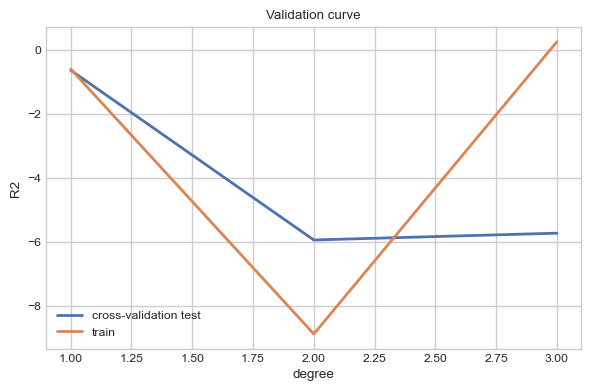

In [599]:
degrees = range(1,4)
a = []
c = []
for deg in degrees:
  numerical_preprocessor = Pipeline([
    ('scaler', StandardScaler()),
    ('poly2', PolynomialFeatures(degree=deg))])
  preprocessor = ColumnTransformer(
    [
        ("ctg", categorical_preprocessor, categorical_columns),
        ("num", numerical_preprocessor, numerical_columns),
    ])
  poly_lr = Pipeline([
    ('pre', preprocessor),
    ('lr', LinearRegression())])
  poly_lr.fit(X_train, y_train)
  cv_models = cross_validate(estimator=poly_lr,
                        X=X_train,
                        y=y_train,
                        return_estimator=True,
                        cv=10,
                        n_jobs=1)
  cv_fit = cv_models['estimator']
  c.append(r2_score(np.exp(y_train),np.exp(poly_lr.predict(X_train))))
  b = []
  for i in range(len(cv_fit)):
    b.append(r2_score(np.exp(y_test),np.exp(cv_fit[i].predict(X_test))))
  a.append(np.mean(b))
plt.figure(figsize=(6, 4))

plt.plot(degrees, a, lw=2,
         label='cross-validation test')
plt.plot(degrees, c, lw=2, label='train')

plt.legend(loc='best')
plt.xlabel('degree')
plt.ylabel('R2')
plt.title('Validation curve')
plt.tight_layout()

Polünomiaalregressiooni astme validatsioonikõverad (ristvalideerimise testandmetel ja treeningandmete) ei ole paralleelsed. Samas, nende kujud on iseloomustatud erievate murdenurgaga keskel. Ristvalideerimise test joon (sinine) läheb R2 väärtuse skaalas nullist alla -6 ni, ning sealt mutdub horisontaalse joonena edasi. Train joon läheb ka alla R2 -8 väärtuseni ja sealt murdub terava nurgaga umbes 90 kraadi ülesse.

Selline mudeli käitumine võib vajada täiendavat uurimist ja modelleerimist selleks, et parandada mudeli ennustusvõimet ning vältida ületreenimist. Võimalikud lahendused on mudeli lihtsustamine, regulaariseerimine (nt Ridge või Lasso) või teiste lihtsamate mudelite kaalumist.

# Otsustuspuu regressioon

## Andmete ettevalmistamine

Treening- ja testandmete eraldamine

In [600]:
X = df.drop([_SIHTTUNNUS_],axis=1)
y = df[_SIHTTUNNUS_]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Konveier (pipeline) otsustuspuu regressioonimudelile

Konveier (Pipeline) kombineerib erinevad teisendused ja ennustajad kokku ühendobjektiks.

### Numbriliste ja kategooriliste muutujate mudelis kasutamine.

Eraldame kategoorilised ja numbrilised muutujad, kasutades nende identifitseerimiseks nende andmetüüpe. Nagu nägime eelnevalt, objekt vastab kategoorilistele veergudele. Kasutame vastavate veergude valimiseks make_column_selector.

In [601]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

numerical_columns

['EEtot',
 'METS',
 'Rf',
 'VT',
 'VE',
 'O2exp',
 'CO2exp',
 'FeO2',
 'FeCO2',
 'VO2.HR',
 'HR']

In [602]:
categorical_columns

['gender', 'original_activity_labels', 'predicted_activity_label']

Me peame numbrilised ja kategoorilised andmeid valmistama ette modelleerimiseks erinevalt: kategoorilised andmed: tunnuste väärtuste indikaatortunnustega asendamine (one-hot encoding), numbrilised andmed: standardiseerimine/normaliseerimine. Scikit-learn pakub klassi ColumnTransformer, mis lubab jaotada konveieri (pipeline) kaheks osaks, edastades konkreetsed veerud konkreetsetele teisendusmeetoditele. See lubab ühendada mõlemat liiki muutujaid ühes konveieris koos.

In [603]:
categorical_preprocessor = OneHotEncoder(drop='first')

Eelprotsessor numbriliste tunnuste jaoks:

In [604]:
numerical_preprocessor = StandardScaler()

Nüüd loome ColumnTransfomer ja seostame eelprotsessorid vastavate veergudega:

In [605]:
preprocessor = ColumnTransformer(
    [
        ("ctg", categorical_preprocessor, categorical_columns),
        ("num", numerical_preprocessor, numerical_columns),
    ]
)
tree_pipe = Pipeline([
    ('pre', preprocessor),
    ('tree', DecisionTreeRegressor(random_state=0))])
tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('ctg',
                                                  OneHotEncoder(drop='first'),
                                                  ['gender',
                                                   'original_activity_labels',
                                                   'predicted_activity_label']),
                                                 ('num', StandardScaler(),
                                                  ['EEtot', 'METS', 'Rf', 'VT',
                                                   'VE', 'O2exp', 'CO2exp',
                                                   'FeO2', 'FeCO2', 'VO2.HR',
                                                   'HR'])])),
                ('tree', DecisionTreeRegressor(random_state=0))])

In [606]:
print('Keskmine R2 täpsus treeningandmetel: %.3f' % tree_pipe.score(X_train, y_train))
print('Keskmine R2 täpsus testandmetel: %.3f' % tree_pipe.score(X_test, y_test))

Keskmine R2 täpsus treeningandmetel: 1.000
Keskmine R2 täpsus testandmetel: 0.976


RMSE enne pöördteisenduse *exp()*:

In [607]:
y_pred = tree_pipe.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Random Forest mudeli RMSE testandmetel: {(rmse):.3f}")

Random Forest mudeli RMSE testandmetel: 1.610


Rakendame pöördtesendust exp():

In [608]:
print('R2 täpsus treeningandmetel: %.3f' % r2_score(np.exp(y_train),np.exp(tree_pipe.predict(X_train))))
print('R2 täpsus testandmetel: %.3f' % r2_score(np.exp(y_test),np.exp(tree_pipe.predict(X_test))))

R2 täpsus treeningandmetel: 1.000
R2 täpsus testandmetel: 0.778


RMSE peale pöördteisenduse *exp()*:

In [609]:
y_pred = np.exp(tree_pipe.predict(X_test))
mse = mean_squared_error(np.exp(y_test), y_pred)
rmse = np.sqrt(mse)
print(f"Random Forest mudeli RMSE testandmetel: {(rmse):.3f}")

Random Forest mudeli RMSE testandmetel: 123534922606145097832278681485981796794368.000


Mudel on ületreenitud

Mudeli tähtsamad argumendid:

In [610]:
imp = pd.DataFrame(tree_pipe[1].feature_importances_)
ft = pd.DataFrame(preprocessor.get_feature_names_out())
ft_imp = pd.concat([ft,imp],axis=1)
ft_imp.columns = ['Feature', 'Importance']
ft_imp.sort_values(by='Importance',ascending=False)

Feature  Importance
28                                        num__VE      0.9461
0                                ctg__gender_male      0.0187
34                                        num__HR      0.0068
33                                    num__VO2.HR      0.0066
25                                      num__METS      0.0062
32                                     num__FeCO2      0.0039
30                                    num__CO2exp      0.0024
31                                      num__FeO2      0.0024
24                                     num__EEtot      0.0022
26                                        num__Rf      0.0021
29                                     num__O2exp      0.0009
27                                        num__VT      0.0007
16              ctg__original_activity_labels_nan      0.0002
2     ctg__original_activity_labels_lyingDownLeft      0.0001
12      ctg__original_activity_labels_walkingFast      0.0001
13    ctg__original_activity_labels_walkingNormal      0.0001
21         ctg__predicted_activity_label_standing      0.0001
8          ctg__original_activity_labels_standing      0.0001
23              ctg__predicted_activity_label_nan      0.0001
11   ctg__original_activity_labels_vacuumCleaning      0.0001
7    ctg__original_activity_labels_stakingShelves      0.0000
20          ctg__predicted_activity_label_sitting      0.0000
22          ctg__predicted_activity_label_walking      0.0000
14      ctg__original_activity_labels_walkingSlow      0.0000
3    ctg__original_activity_labels_lyingDownRight      0.0000
17        ctg__predicted_activity_label_household      0.0000
4      ctg__original_activity_labels_sittingChair      0.0000
1       ctg__original_activity_labels_dishwashing      0.0000
6       ctg__original_activity_labels_sittingSofa      0.0000
9              ctg__original_activity_labels_step      0.0000
19        ctg__predicted_activity_label_lyingDown      0.0000
5      ctg__original_activity_labels_sittingCouch      0.0000
15  ctg__original_activity_labels_walkingStairsUp      0.0000
10      ctg__original_activity_labels_syncJumping      0.0000
18          ctg__predicted_activity_label_jumping      0.0000

In [611]:
from sklearn.model_selection import GridSearchCV

In [612]:
parameters={"tree__splitter":["best","random"],
            "tree__max_depth" : [1,3,5,7,9,11,12],
           "tree__min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "tree__max_features":["log2","sqrt",None],
           "tree__max_leaf_nodes":[None,10,20,30,40,50] }

gs_tree_pipe = GridSearchCV(estimator=tree_pipe, param_grid=parameters, cv=5, verbose=0)

gs_tree_pipe.fit(X_train, y_train)

gs_tree_pipe.best_params_

Mudeli täpsus enne pöördteisenduse rakendamist:

In [ ]:
print(f"R2 score on train: {gs_tree_pipe.score(X_train, y_train):.3f}")
print(f"R2 score on train: {gs_tree_pipe.score(X_test, y_test):.3f}")

RMSE enne pöördteisenduse *exp*:

In [ ]:
y_pred = gs_tree_pipe.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Random Forest mudeli RMSE testandmetel: {(rmse):.3f}")

Mudeli täpsus pärast pöördteisenduse exp() rakendamist:

In [ ]:
print(f"R2 score on train: {r2_score(np.exp(y_train),np.exp(gs_tree_pipe.predict(X_train))):.3f}")
print(f"R2 score on test: {r2_score(np.exp(y_test),np.exp(gs_tree_pipe.predict(X_test))):.3f}")

RMSE peale pöördteisenduse *exp()*:

In [ ]:
y_pred = np.exp(gs_tree_pipe.predict(X_test))
mse = mean_squared_error(np.exp(y_test), y_pred)
rmse = np.sqrt(mse)
print(f"Random Forest mudeli RMSE testandmetel: {(rmse):.3f}")

R2 on kõrgem treeningandmetel VV% võrra ja testandmetel DD% võrra.

## Konveier (pipeline): Random Forest regressioon

Mudeli loomine treeningandmetel

Loome *Pipeline*'i, mis ühendab andmete eeltöötlemise ja Random Forest regressioonmudeli, ning seejärel treenib mudeli kasutades etteantud treeningandmeid.

In [ ]:
rf_pipe = Pipeline([
    ('pre', preprocessor),
    ('rf', RandomForestRegressor(random_state=0))])

rf_pipe.fit(X_train, y_train)

In [ ]:
print('Keskmine R2 täpsus treeningandmetel: %.3f' % rf_pipe.score(X_train, y_train))
print('Keskmine R2 täpsus testandmetel: %.3f' % rf_pipe.score(X_test, y_test))

Rakendame pöördtesendust exp(), mudeli parandamiseks.

In [ ]:
print('R2 täpsus treeningandmetel: %.3f' % r2_score(np.exp(y_train),np.exp(rf_pipe.predict(X_train))))
print('R2 täpsus testandmetel: %.3f' % r2_score(np.exp(y_test),np.exp(rf_pipe.predict(X_test))))

Mudeli tähtsamad argumendid:

In [ ]:
imp = pd.DataFrame(rf_pipe[1].feature_importances_)
ft = pd.DataFrame(preprocessor.get_feature_names_out())
ft_imp = pd.concat([ft,imp],axis=1)
ft_imp.columns = ['Feature', 'Importance']
ft_imp.sort_values(by='Importance',ascending=False)

*GridSearchCV* kasutamine võimaldab Random Forest mudeli hüperparameetrite optimeerimist ning eeldatavasti tagab kõrgemat täpsust.
Kasutame parameetrite *GridSearchCV* tuunimist:

In [ ]:
# param_grid_rf = {
#     'rf__n_estimators': [10, 50, 100, 500, 1000],
#     'rf__max_features': ['log2', 'sqrt', 0.8,1]
# }

param_grid_rf = {
    'rf__n_estimators': [10, 50, 100],
    'rf__max_features': ['log2', 'sqrt', 0.8,1]
}

gs_rf_pipe = GridSearchCV(estimator=rf_pipe, param_grid=param_grid_rf, cv=5, verbose=0)

gs_rf_pipe.fit(X_train, y_train)

gs_rf_pipe.best_params_

Mudeli täpsus enne pöördteisenduse rakendamist:

In [ ]:
print(gs_rf_pipe.score(X_train, y_train))
print(gs_rf_pipe.score(X_test, y_test))

Mudeli täpsus peale pöördteisenduse exp() rakendamist:

In [ ]:
print(f"R2 score on train: {r2_score(np.exp(y_train),np.exp(gs_rf_pipe.predict(X_train))):.3f}")
print(f"R2 score on test: {r2_score(np.exp(y_test),np.exp(gs_rf_pipe.predict(X_test))):.3f}")

Mudeli kirjeldusvõime peaaegu sama. R2 tõusis ainult 0.2% võrra treeningandmetel ja 0.9% võrra testandmetel.

RMSE peale *GridSearchCV* tuunimist ja peale pöördteisendust *exp()*:

In [ ]:
y_pred = np.exp(gs_rf_pipe.predict(X_test))
mse = mean_squared_error(np.exp(y_test), y_pred)
rmse = np.sqrt(mse)
print(f"Random Forest mudeli RMSE testandmetel: {(rmse):.3f}")

Mudeli argumendid:

In [ ]:
preprocessor.get_feature_names_out()

Mudeli kordajad:

In [ ]:
# rf_pipe = Pipeline([
#     ('pre', preprocessor),
#     ('rf',RandomForestRegressor(max_features='log2', n_estimators= 1000))])

rf_pipe = Pipeline([
    ('pre', preprocessor),
    ('rf',RandomForestRegressor(max_features='log2', n_estimators= 100))])
rf_pipe.fit(X_train, y_train)

In [ ]:
imp = pd.DataFrame(rf_pipe[1].feature_importances_)
ft = pd.DataFrame(preprocessor.get_feature_names_out())
ft_imp = pd.concat([ft,imp],axis=1)
ft_imp.columns = ['Feature', 'Importance']
ft_imp.sort_values(by='Importance',ascending=False)

Peale *GridSearchCV* tuunimist kordajate tähtsuste väärtused on langenud ca. 30% võrra (tähtsamatel kordajatel).
Kõige tähtsamad kordajad:
* 21	num__acousticness	0.3063
* 19	num__loudness	0.2679
* 24	num__valence	0.0769
* 20	num__speechiness	0.0669
* 18	num__danceability	0.0478